In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os

import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

# Calculate the Binary LGE hit or miss ratios
Between LGE Segments and Segments defined by Circle or Tarique

## Column: 'Tarique abnormal'

bullsplot used here
tarique, bullsplot, motion curves
11 - mid inferolateral 

first: quality check: single segments only is very rare, two segments are better/more often that means more plausible. Not just the septum is affected. If all segments are affected, tracking may be wrong. 
second: based on experience, 11 and 12 AHA are mostly affected. Check also on circumferential and radial strain values, are they low? Bullseye plot is used for help.

## Column: 'Strain diff' 

Bezieht sich auf die orginal column: 'Segment from strain if different'

- tarique says this is difference between D and F
- tarique says this column is not helpful
- tarique says this columns relates to if different from LGE

He also said that this column shows the additional segments when he applies the Strain thresholding



# Define some helper functions

In [2]:

def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 2
    
    clf1 = LogisticRegression(random_state=1, class_weight='balanced')
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), 
             
            ('lr', clf1), 
            ('rf', clf2), 
            ('svc', clf6),
            ('svc2', clf7)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        
        
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()

# Read the dmd dataframe with all timesteps

In [3]:
from ipyfilechooser import FileChooser
import os
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/sds/sd20i001/'), '')
display(path_chooser)

FileChooser(path='/mnt/sds/sd20i001', filename='', title='HTML(value='', layout=Layout(display='none'))', show…

In [4]:
#/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2
#df_strain_comp = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_ed2p.csv')
#df_strain_p2p = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_p2p.csv')
df_strain_comp = pd.read_csv(os.path.join(path_chooser.selected, 'df_DMD_time_ed2p.csv'))
df_strain_p2p = pd.read_csv(os.path.join(path_chooser.selected,'df_DMD_time_p2p.csv'))
df_strain_comp.sort_values(by=['pat', 'aha'], inplace=True)
df_strain_p2p.sort_values(by=['pat', 'aha'], inplace=True)
print(df_strain_comp[df_strain_comp.isna().any(axis=1)])
print(df_strain_p2p[df_strain_p2p.isna().any(axis=1)])
print(df_strain_comp.shape)
print(df_strain_p2p.shape)
df_strain_comp.head()
# we need to make sure that we differentate lge pos/neg on a patient level on all segments, not only on the segments of interest
y = (df_strain_p2p.sort_values(['pat']).groupby('pat')['lge'].sum()>0).values
print(y.sum())
print((y==False).sum())

Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
(4480, 7)
(4480, 7)
32
24


In [6]:
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp = df_strain_p2p_positive.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_pos.xlsx'))

In [7]:
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp = df_strain_p2p_negative.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_neg.xlsx'))

In [8]:
# Calc the mean/std for the phase2phases strain per patient, export as xlsx
temp = df_strain_p2p.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_mean.xlsx'))

In [9]:
# Calc the mean/std for the composed strain per patient, export as xlsx
temp = df_strain_comp.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_comp.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_comp_mean.xlsx'))

In [10]:
temp

our_rs_mean  our_cs_mean  our_rs_std  our_cs_std
aha phase                                                  
1   0         0.879806     0.089290    0.398987    0.068014
    1         1.075437     0.148970    0.605217    0.093149
    2         0.658606     0.071887    0.321721    0.048374
    3         0.111531     0.001926    0.081021    0.012156
    4         0.003178     0.004315    0.009424    0.006549
...                ...          ...         ...         ...
16  0         0.272984     0.000857    0.181541    0.032843
    1         0.709379    -0.005076    0.257008    0.040408
    2         0.287029    -0.015934    0.230191    0.030687
    3         0.018638    -0.003388    0.015524    0.005383
    4        -0.004293     0.005913    0.008082    0.012554

[80 rows x 4 columns]

In [5]:
# test, if we use only the mid-cavity segments, this performs better, than taking all segments into account
# only freewall
#segments_of_interest = [5,6,11,12]
# only mid-cavity
#segments_of_interest =[7,8,9,10,11,12]
#df_strain_p2p = df_strain_p2p[df_strain_p2p['aha'].isin(segments_of_interest)]
#df_strain_comp = df_strain_comp[df_strain_comp['aha'].isin(segments_of_interest)]

NameError: name 'segments_of_interest' is not defined

In [6]:
df_strain_comp.head()

pat  aha  phase    our_rs    our_cs  soa  lge
0  aa_20180710    1      0  0.915333  0.177148  0.0  0.0
1  aa_20180710    1      1  0.930618  0.226990  0.0  0.0
2  aa_20180710    1      2  0.596300  0.108193  0.0  0.0
3  aa_20180710    1      3  0.220566  0.043842  0.0  0.0
4  aa_20180710    1      4  0.005196 -0.000394  0.0  0.0

# Violinplots of RS/CS per phase grouped by binary lge

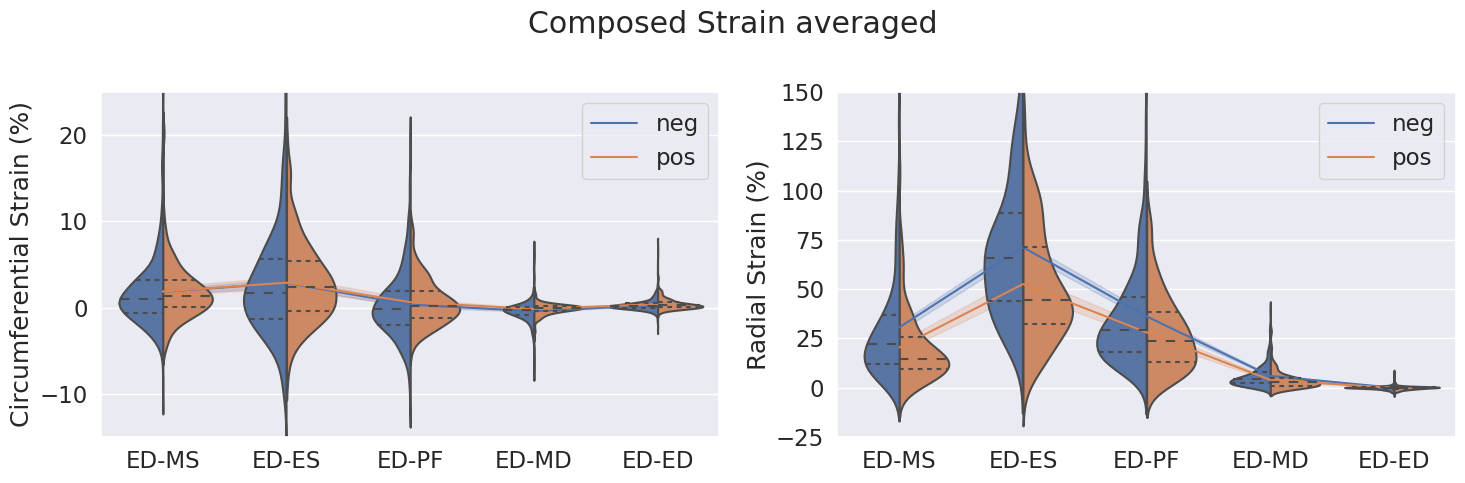

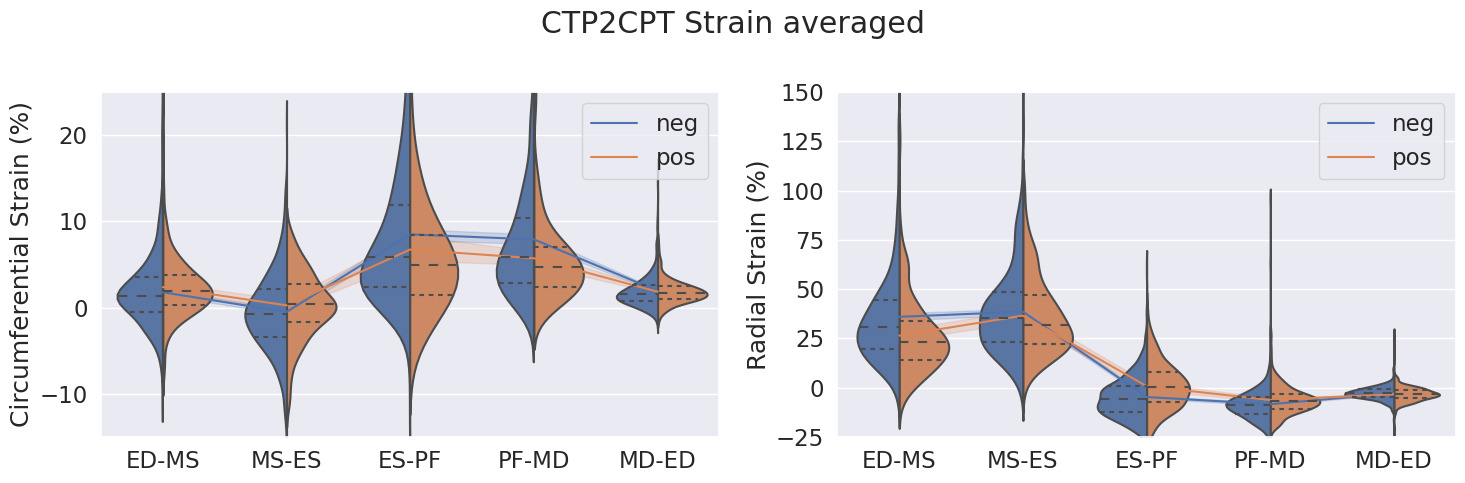

In [7]:
def plot_strain_per_time(df, title=None, p2p=False):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if p2p:
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    else:
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                 hue="lge",err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, split=True,hue='lge')
    _ = ax1.set_ylim((-15., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue="lge",err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, split=True,hue='lge')

    _ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig
    
#print('*'*20,'strain composed','*'*20)
_ = plot_strain_per_time(df_strain_comp,title='Composed Strain averaged',p2p=False); plt.show()
#print('*'*20,'strain p2p','*'*20)
_ = plot_strain_per_time(df_strain_p2p, title='CTP2CPT Strain averaged',p2p=True);plt.show()

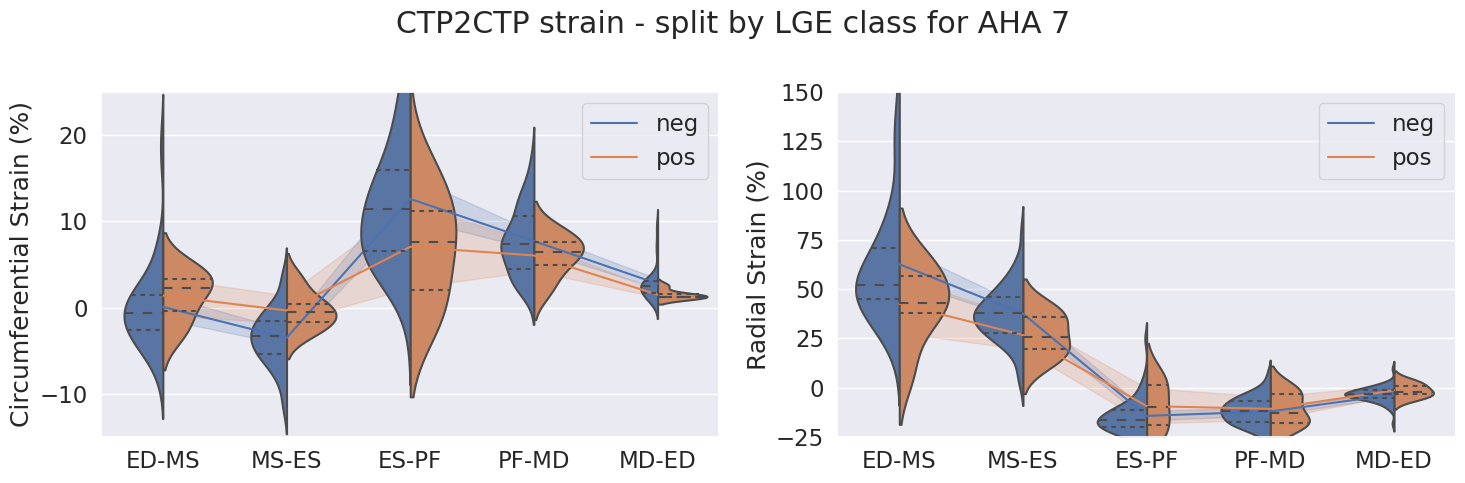

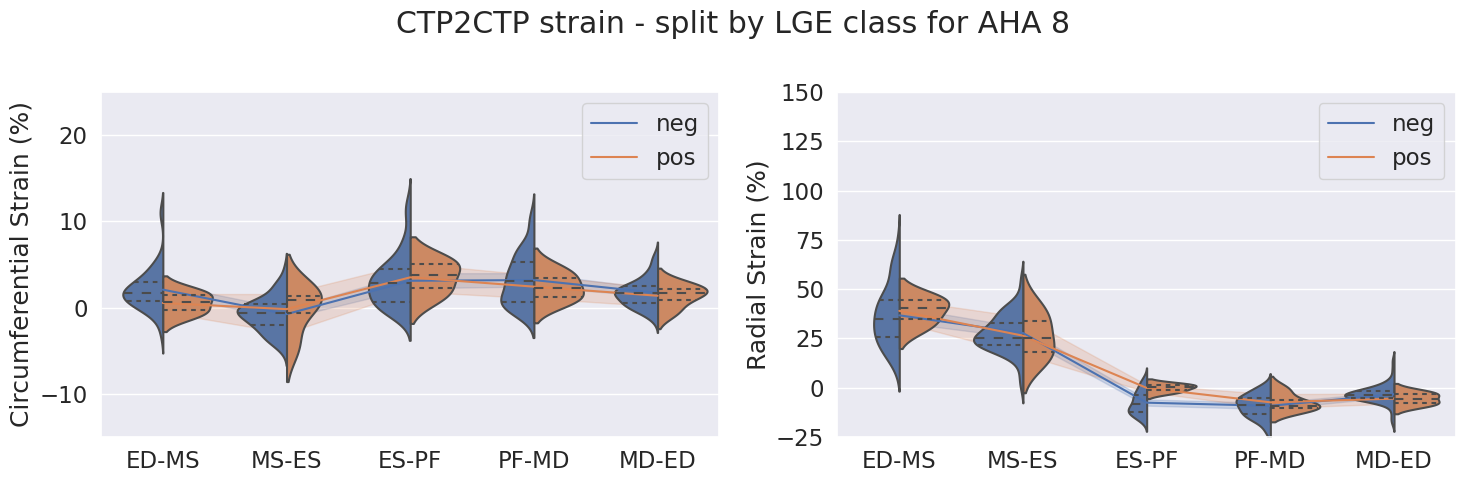

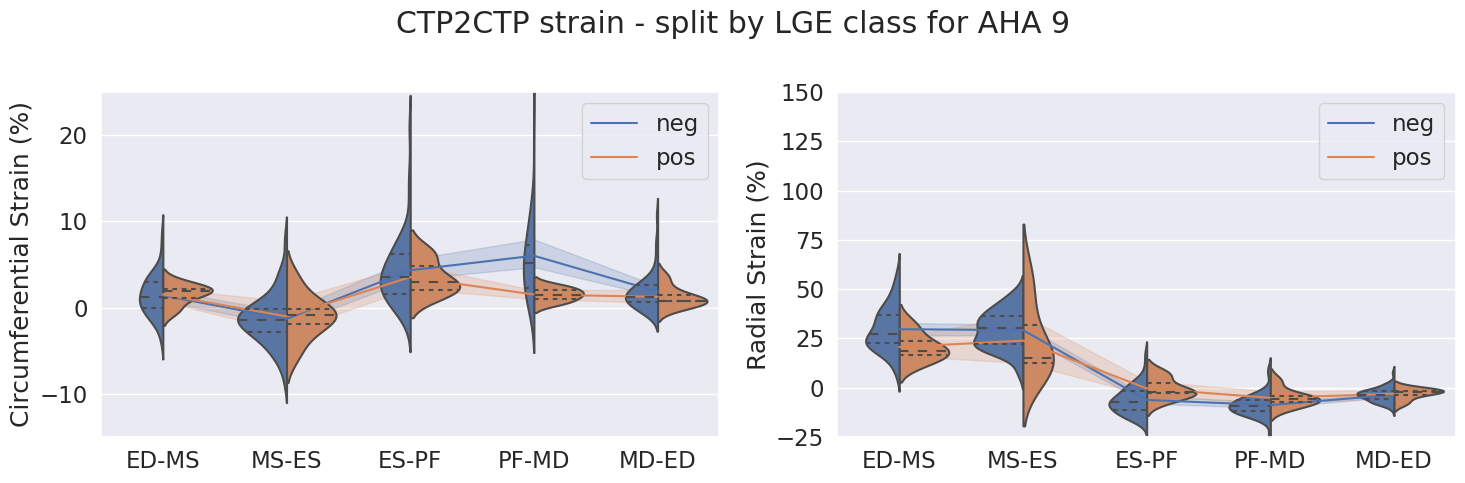

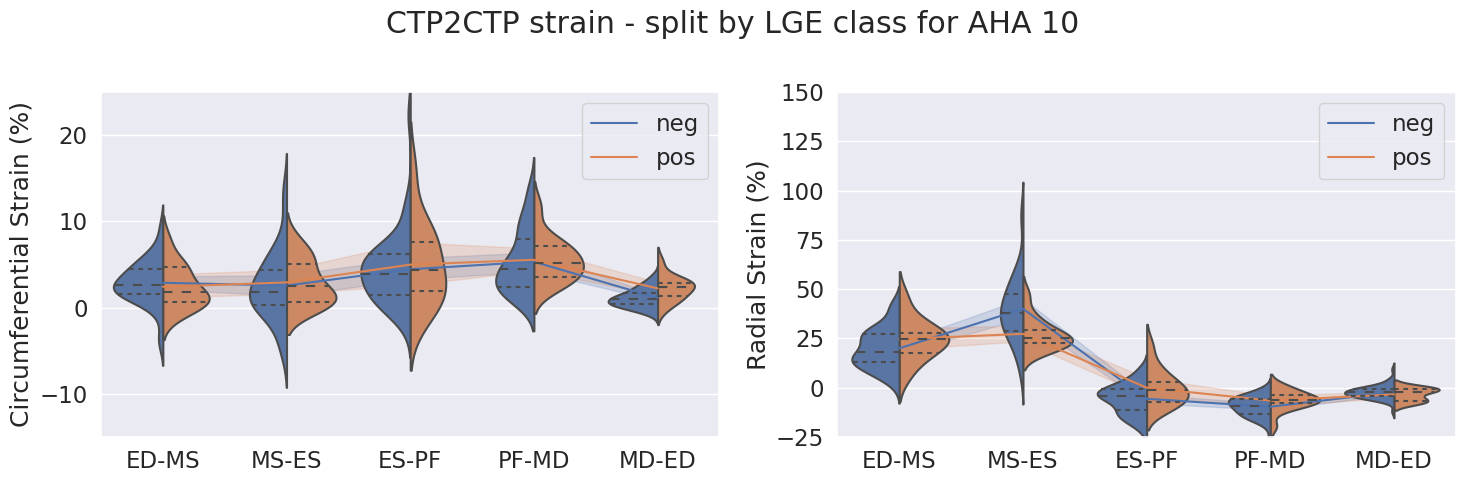

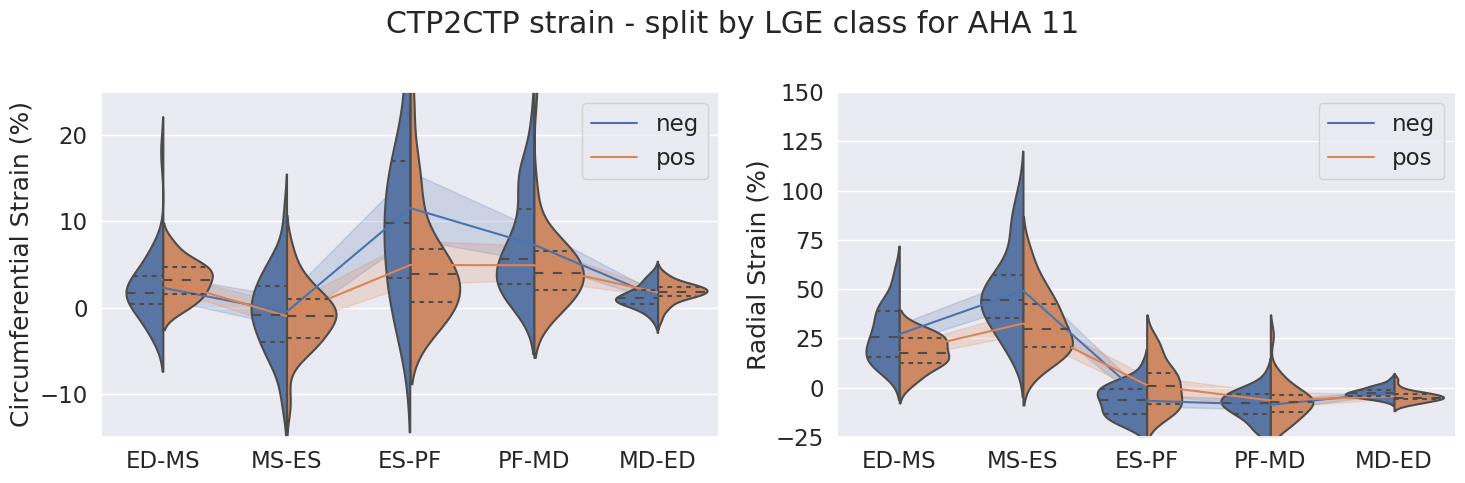

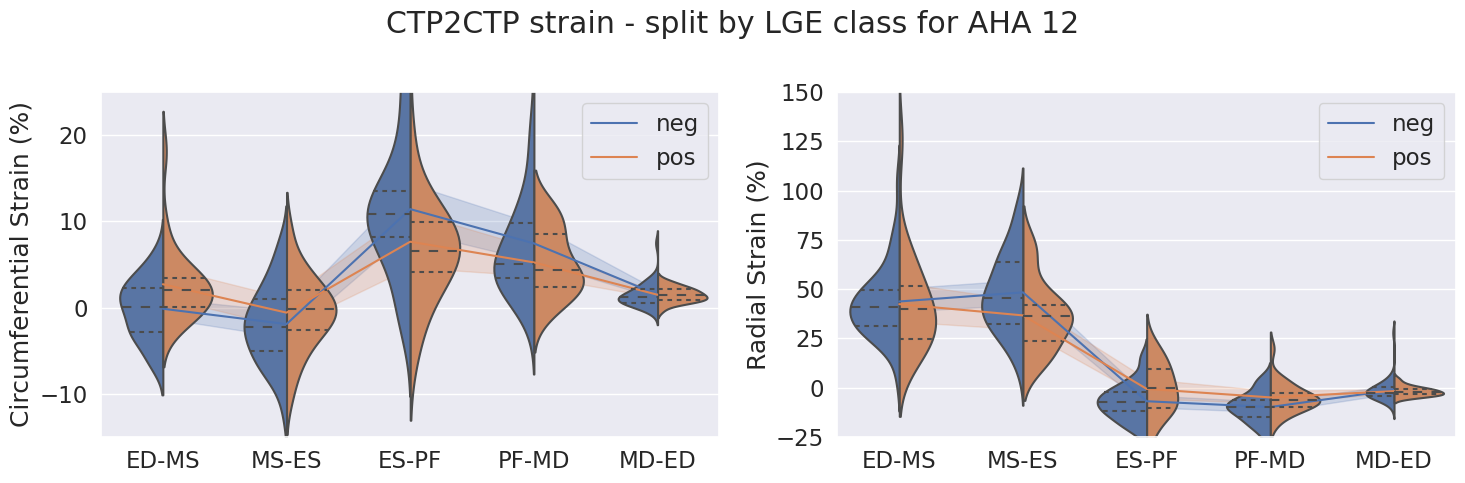

In [13]:
# plot one violinplot per mid-cavity segment for the p2p strains
for i in segments_of_interest:
    temp = df_strain_p2p[df_strain_p2p['aha']==i]
    _ = plot_strain_per_time(temp, title="CTP2CTP strain - split by LGE class for AHA {}".format(i), p2p=True)

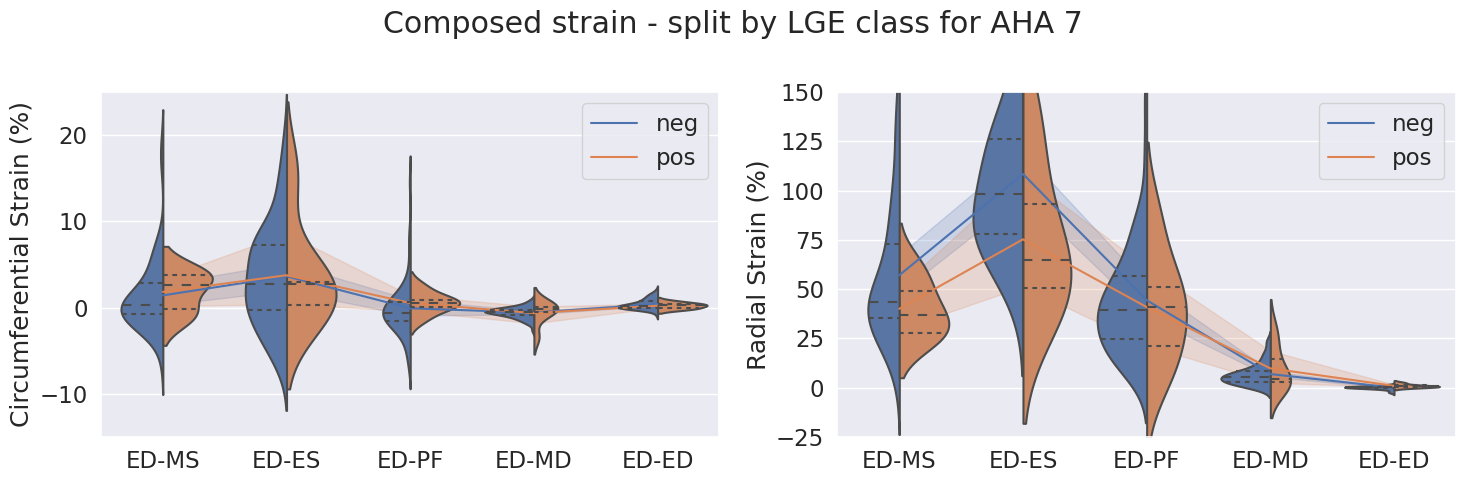

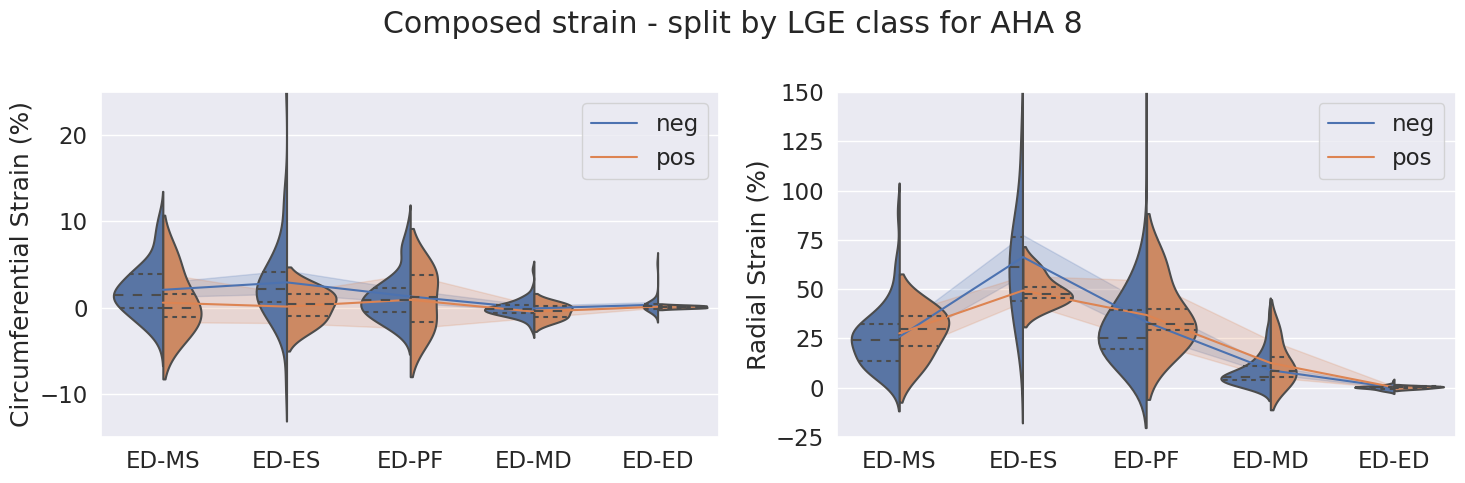

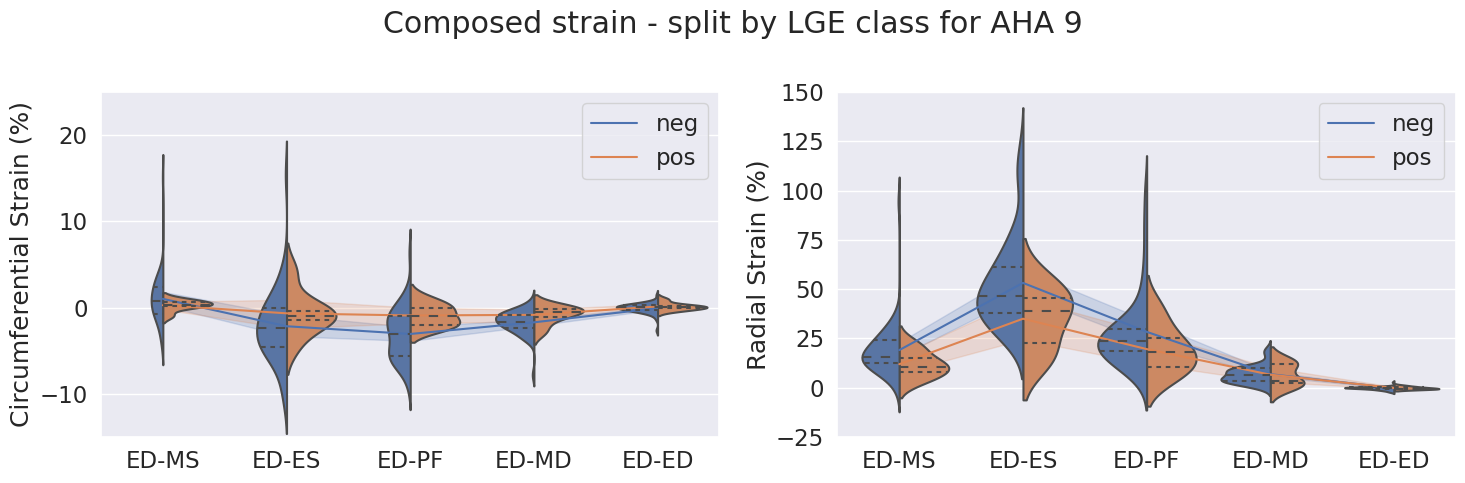

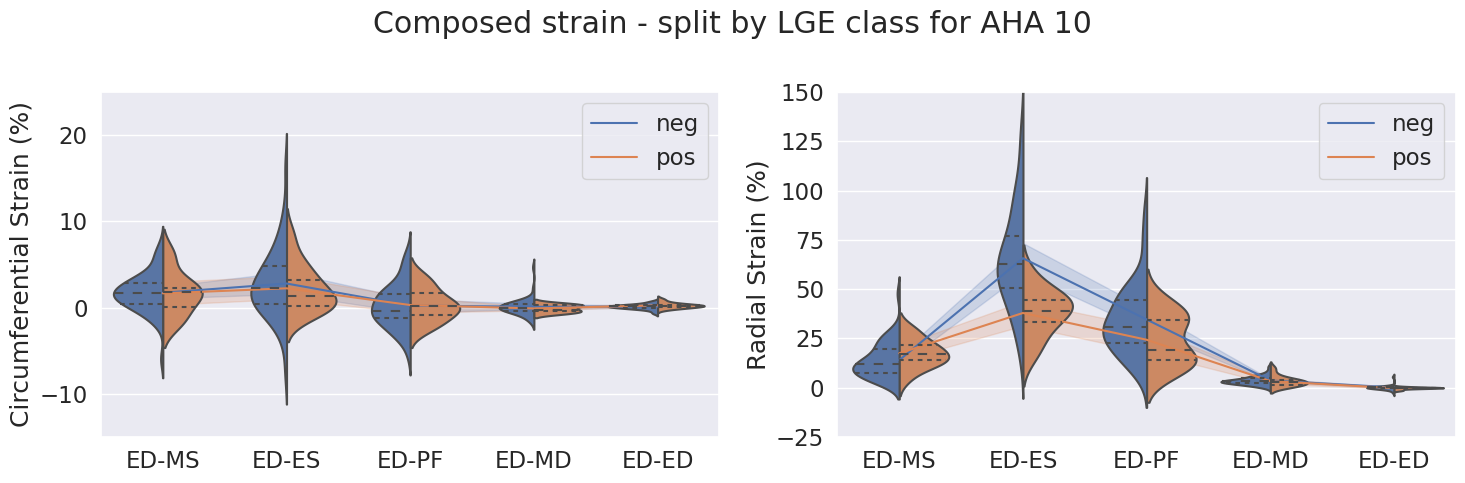

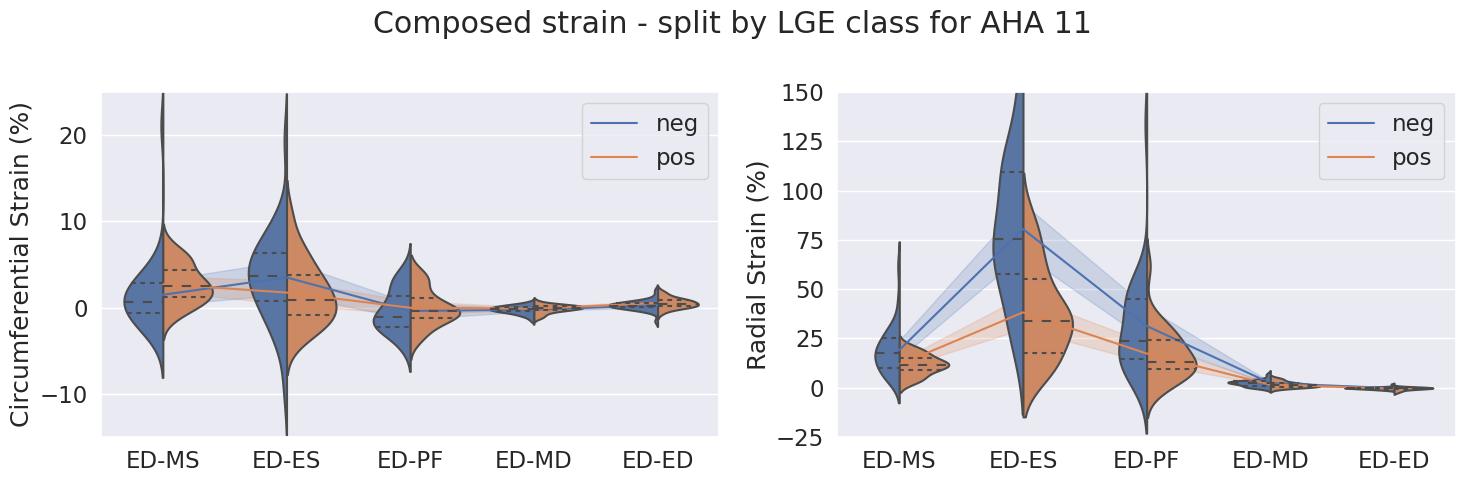

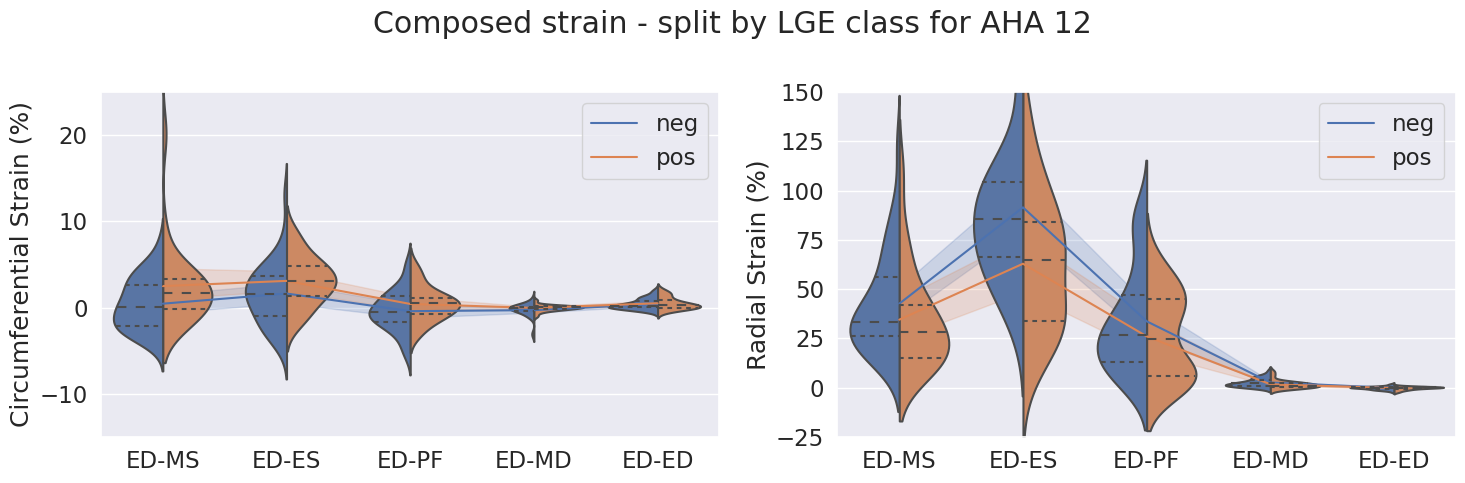

In [14]:
# plot one violinplot per mid-cavity segment for the comp strains
for i in segments_of_interest:
    temp = df_strain_comp[df_strain_comp['aha']==i]
    _ = plot_strain_per_time(temp, title="Composed strain - split by LGE class for AHA {}".format(i), p2p=False)

In [15]:
#df_strain_comp.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#df_strain_p2p.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [77]:
#df_strain_comp = df_strain_comp[~df_strain_comp['pat'].isin(['wc_20181015'])]
#df_strain_p2p = df_strain_p2p[~df_strain_p2p['pat'].isin(['wc_20181015'])]

# Identify pcs und prs 
- by max/min or by 
- a pre-defined phase (eg.: ES)

In [9]:
def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

# peak radial and circumferential strain
# for the composed and p2p strain values
prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)
    
# 56 patients x 16 segments = 896 --> Peak strain per patient and segment
df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

# composed phase
df_peak['prs_com_p']=prs_com_p
df_peak['pcs_com_p']=pcs_com_p
# composed arg-min/max
df_peak['prs_com_arg']=prs_com_arg
df_peak['pcs_com_arg']=pcs_com_arg
# p2p phase
df_peak['prs_p2p_p']=prs_p2p_p
df_peak['pcs_p2p_p']=pcs_p2p_p
# p2p arg-min/max
df_peak['prs_p2p_arg']=prs_p2p_arg
df_peak['pcs_p2p_arg']=pcs_p2p_arg
# minor cleaning and dtype casting
df_peak.drop(labels='phase', axis=1, inplace=True)
df_peak.drop(labels='our_rs', axis=1, inplace=True)
df_peak.drop(labels='our_cs', axis=1, inplace=True)
df_peak.sort_values(by=['pat', 'aha'], inplace=True)
df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
print(df_peak.dtypes)
print(df_peak.shape)

df_peak.head()

pat             object
aha            float32
soa            float32
lge            float32
prs_com_p      float32
pcs_com_p      float32
prs_com_arg    float32
pcs_com_arg    float32
prs_p2p_p      float32
pcs_p2p_p      float32
prs_p2p_arg    float32
pcs_p2p_arg    float32
dtype: object
(896, 12)


pat  aha  soa  lge  prs_com_p  pcs_com_p  prs_com_arg  \
0   aa_20180710  1.0  0.0  0.0   0.930618   0.226990     0.930618   
5   aa_20180710  2.0  0.0  0.0   0.647063   0.075693     0.647063   
10  aa_20180710  3.0  0.0  0.0   0.193750  -0.026550     0.193750   
15  aa_20180710  4.0  0.0  0.0   0.301456   0.009213     0.301456   
20  aa_20180710  5.0  0.0  0.0   0.540338   0.040706     0.540338   

    pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
0     -0.000394   0.940246   0.045605     0.940246     0.035338  
5      0.000396   0.313685   0.039412     0.313685     0.001586  
10    -0.026550   0.149145  -0.026990     0.300861    -0.026990  
15    -0.002673   0.387614   0.124339     0.387614     0.014645  
20    -0.004024   0.744522   0.057000     0.744522    -0.018574

# Examples of dataframe grouby

In [13]:
temp_y = np.stack(df_strain_comp.groupby(['phase'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(5, 896)
LGE positive patients:  176
LGE negative patients:  720


In [14]:
temp_y = np.stack(df_strain_comp.groupby(['phase','aha'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(80, 56)
LGE positive patients:  32
LGE negative patients:  24


In [15]:
# best groupby selection for patient and segment based target y
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 80)
LGE positive segments:  880
LGE negative segments:  3600
LGE positive patients:  32
LGE negative patients:  24


In [15]:
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 4)
LGE positive patients:  32
LGE negative patients:  24


# Peak Strain via argmax or static phase slicing

Phases: [0:4] --> ED,MS,ES,PF,MD
Usually min(cs) and max(rs) should reflect the phase MS--> ES, which sould be phase==1

In [17]:
# for a patient based pos/neg splitting we need a list of patients with LGE pos and LGE neg
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
pat_pos = df_strain_comp.pat.unique()[temp_y_patients==True]
pat_neg = df_strain_comp.pat.unique()[temp_y_patients==False]
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 80)
LGE positive segments:  880
LGE negative segments:  3600
LGE positive patients:  32
LGE negative patients:  24


In [18]:
# peak strain values per LGE positive group
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_peak_positive = df_peak[df_peak['pat'].isin(pat_pos)] * 100
df_peak_positive.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count  512.0000 512.0000 512.0000   512.0000   512.0000     512.0000   
mean   850.0000  14.8438  34.3750    62.5448     2.8171      64.6035   
std    461.4280  35.5881  47.5423    38.4864     6.1017      39.0463   
min    100.0000   0.0000   0.0000     1.9103   -13.0622       6.1474   
25%    475.0000   0.0000   0.0000    36.2971    -0.7507      38.0508   
50%    850.0000   0.0000   0.0000    56.5937     1.9371      57.5963   
75%   1225.0000   0.0000 100.0000    79.6072     5.3476      81.1753   
max   1600.0000 100.0000 100.0000   401.5197    42.2057     401.5197   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count     512.0000   512.0000   512.0000     512.0000     512.0000  
mean       -1.5873    34.9408    -0.4009      44.2982      -1.6960  
std         1.9612    19.5826     3.9989      23.4058       3.1119  
min       -13.0622    -4.9929   -20.4149       7.9352     -20.4149  
25%        -2.3349    20.8038    -2.8637      28.2417      -3.1590  
50%        -0.9979    31.3211    -0.3588      39.7521      -1.0391  
75%        -0.1996    44.4703     2.2015      54.1959       0.3579  
max         1.5449   111.2299    13.7452     183.5877       5.1308

In [19]:
# peak strain values per LGE negative group
df_peak_negative = df_peak[df_peak['pat'].isin(pat_neg)] * 100
df_peak_negative.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count  384.0000 384.0000 384.0000   384.0000   384.0000     384.0000   
mean   850.0000   3.3854   0.0000    74.1909     2.9005      77.3200   
std    461.5786  18.1090   0.0000    38.1244     6.6898      38.9398   
min    100.0000   0.0000   0.0000     8.1024   -10.6958      14.6399   
25%    475.0000   0.0000   0.0000    48.7092    -1.5002      51.0815   
50%    850.0000   0.0000   0.0000    68.1166     1.6984      70.0452   
75%   1225.0000   0.0000   0.0000    90.6831     5.8664      92.2919   
max   1600.0000 100.0000   0.0000   266.3976    35.6242     266.3976   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count     384.0000   384.0000   384.0000     384.0000     384.0000  
mean       -2.0539    42.3259    -0.3270      51.2227      -2.2753  
std         2.2325    22.8715     5.2359      25.7633       3.1966  
min       -11.7077    -4.5291   -13.8769       9.2574     -13.8769  
25%        -3.0811    26.0861    -3.8399      34.9363      -4.1157  
50%        -1.3794    38.8601    -0.6399      45.1735      -1.7314  
75%        -0.4245    51.5131     2.8363      61.6073       0.0543  
max         1.6857   144.4499    21.4761     160.9975       4.8625

In [17]:
# does the strain values come from two different distributions
from scipy import stats
# [c for c in df_peak_negative.columns if 'p2p' in c]
@interact
def p_test(col = df_peak_negative.columns):
    try:
        print(df_peak_negative[col].shape)
        return stats.ttest_ind(df_peak_negative[col], df_peak_positive[col])
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='col', options=('pat', 'aha', 'soa', 'lge', 'prs_com_p', 'pcs_com_p…

In [20]:
# segment and phase with the maximal difference between LGE pos and negative group
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp_pos = df_strain_p2p_positive.groupby(['aha','phase']).mean()

df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp_neg = df_strain_p2p_negative.groupby(['aha','phase']).mean()

diff = abs(temp_pos - temp_neg)*100
diff[['our_rs', 'our_cs']]

our_rs  our_cs
aha phase                
1   0     51.9221  5.5982
    1     14.1357  0.2766
    2     23.0474 17.2860
    3      5.7046  6.6409
    4      1.9669  1.8088
...           ...     ...
16  0      7.4837  0.8117
    1      2.0795  2.5301
    2      7.2437  0.5152
    3      3.6000  5.7191
    4      0.8020  0.3691

[80 rows x 2 columns]

******************** strain composed ********************
prs: Counter({1: 755, 2: 85, 0: 56})
pcs: Counter({3: 279, 2: 266, 1: 137, 4: 107, 0: 107})


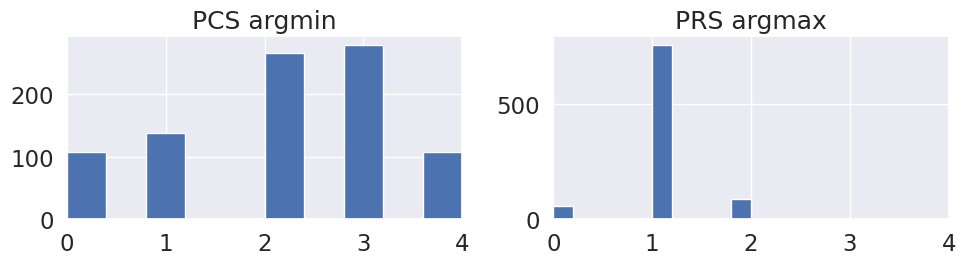

******************** strain p2p ********************
prs: Counter({1: 494, 0: 386, 2: 14, 3: 2})
pcs: Counter({1: 498, 0: 152, 4: 145, 2: 70, 3: 31})


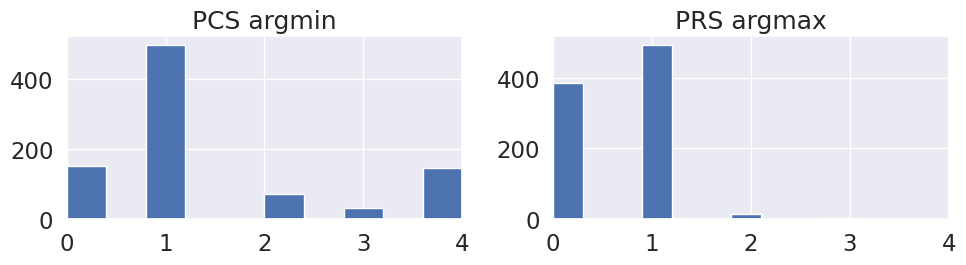

In [21]:
def show_phase_with_max_min_strain(df):
    from collections import Counter
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    # peak radial strain
    rs = np.stack(df.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32)
    # peak circumferential strain
    cs = np.stack(df.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)

    prs_argmax = np.argmax(rs, axis=1)
    pcs_argmin = np.argmin(cs, axis=1)
    print('prs: {}'.format(Counter(prs_argmax)))
    print('pcs: {}'.format(Counter(pcs_argmin)))

    # plot
    ax[0].hist(pcs_argmin)
    ax[0].set_title('PCS argmin')
    ax[0].set_xlim(0,4)
    ax[1].hist(prs_argmax)
    ax[1].set_title('PRS argmax')
    ax[1].set_xlim(0,4)
    plt.tight_layout()
    plt.show()
    
print('*'*20,'strain composed','*'*20)
show_phase_with_max_min_strain(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
show_phase_with_max_min_strain(df_strain_p2p)

prs: Counter({1: 115, 0: 57, 2: 4})
pcs: Counter({1: 89, 0: 32, 4: 25, 2: 21, 3: 9})


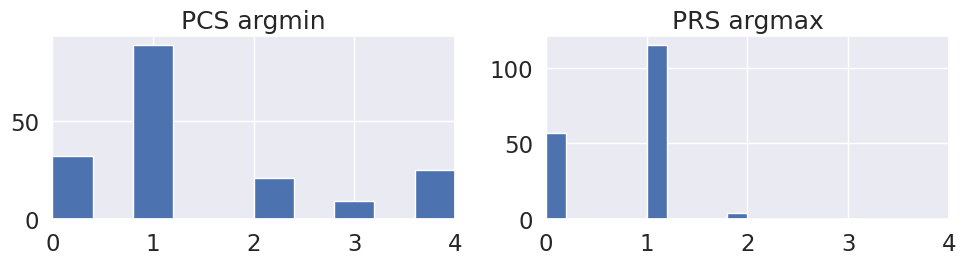

prs: Counter({1: 379, 0: 329, 2: 10, 3: 2})
pcs: Counter({1: 409, 4: 120, 0: 120, 2: 49, 3: 22})


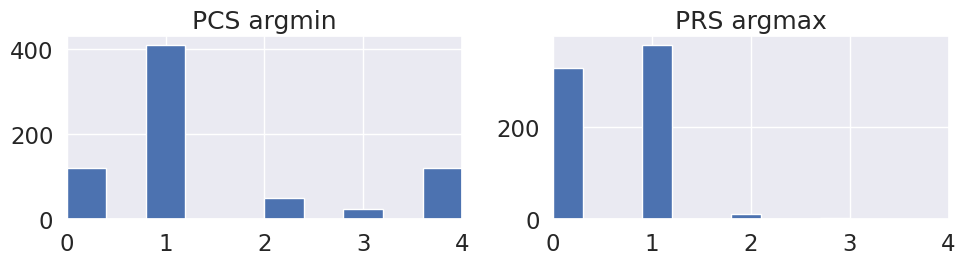

prs: Counter({1: 145, 2: 25, 0: 6})
pcs: Counter({3: 59, 2: 53, 1: 27, 4: 21, 0: 16})


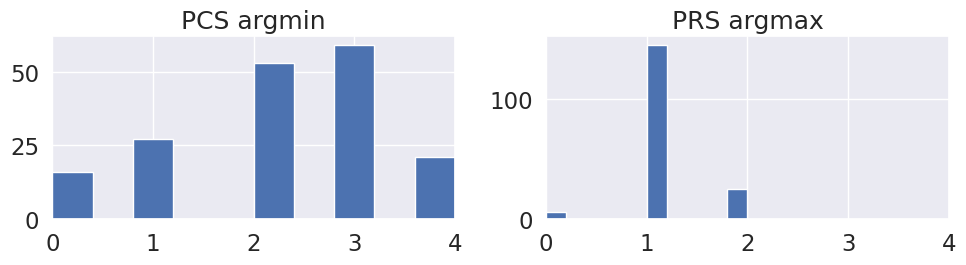

prs: Counter({1: 610, 2: 60, 0: 50})
pcs: Counter({3: 220, 2: 213, 1: 110, 0: 91, 4: 86})


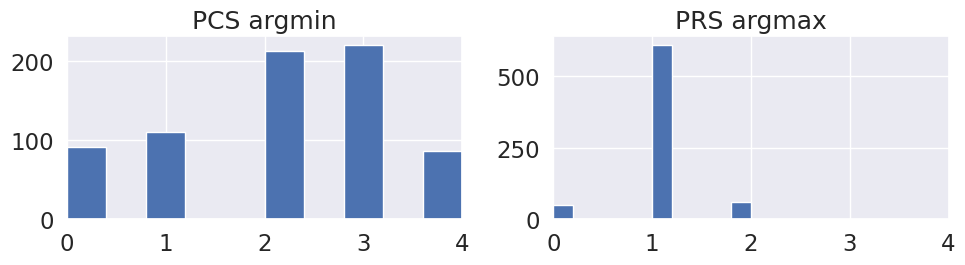

In [22]:
# occurence of the peak and min values per outcome group and strain
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
show_phase_with_max_min_strain(df_strain_p2p_positive)
show_phase_with_max_min_strain(df_strain_p2p_negative)

df_strain_comp_positive = df_strain_comp[df_strain_comp['lge']==1]
df_strain_comp_negative = df_strain_comp[df_strain_comp['lge']==0]
show_phase_with_max_min_strain(df_strain_comp_positive)
show_phase_with_max_min_strain(df_strain_comp_negative)

# Pairplot

## Composed Strain

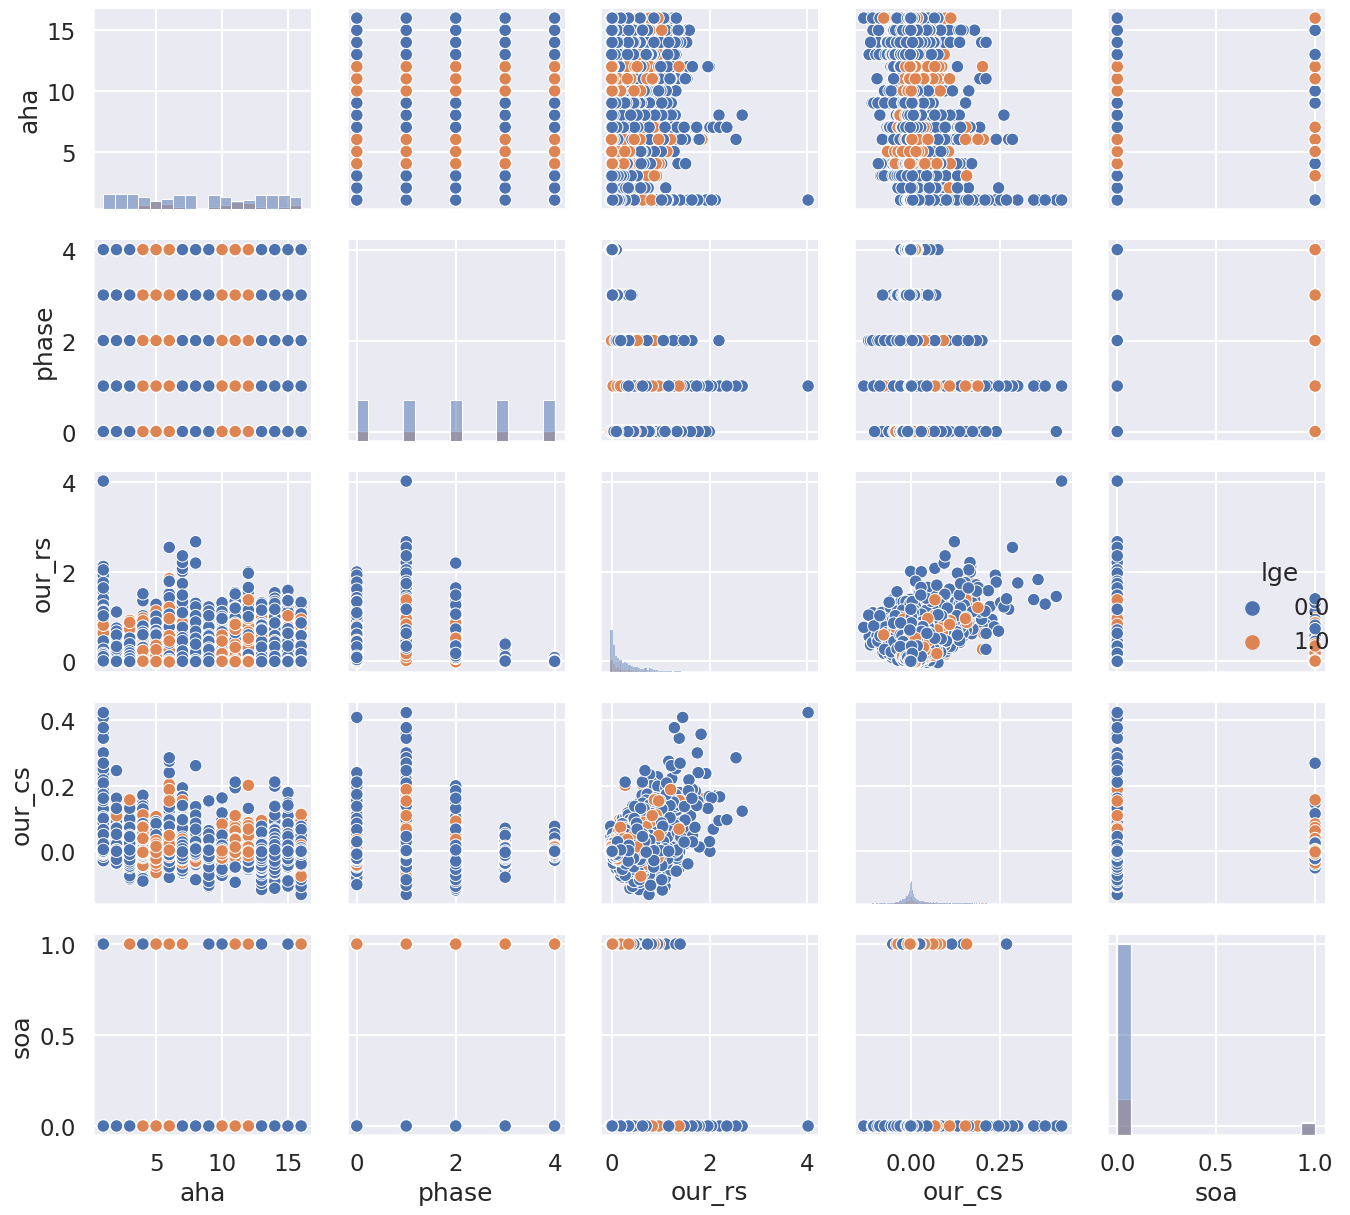

In [23]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_comp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## p2p Strain

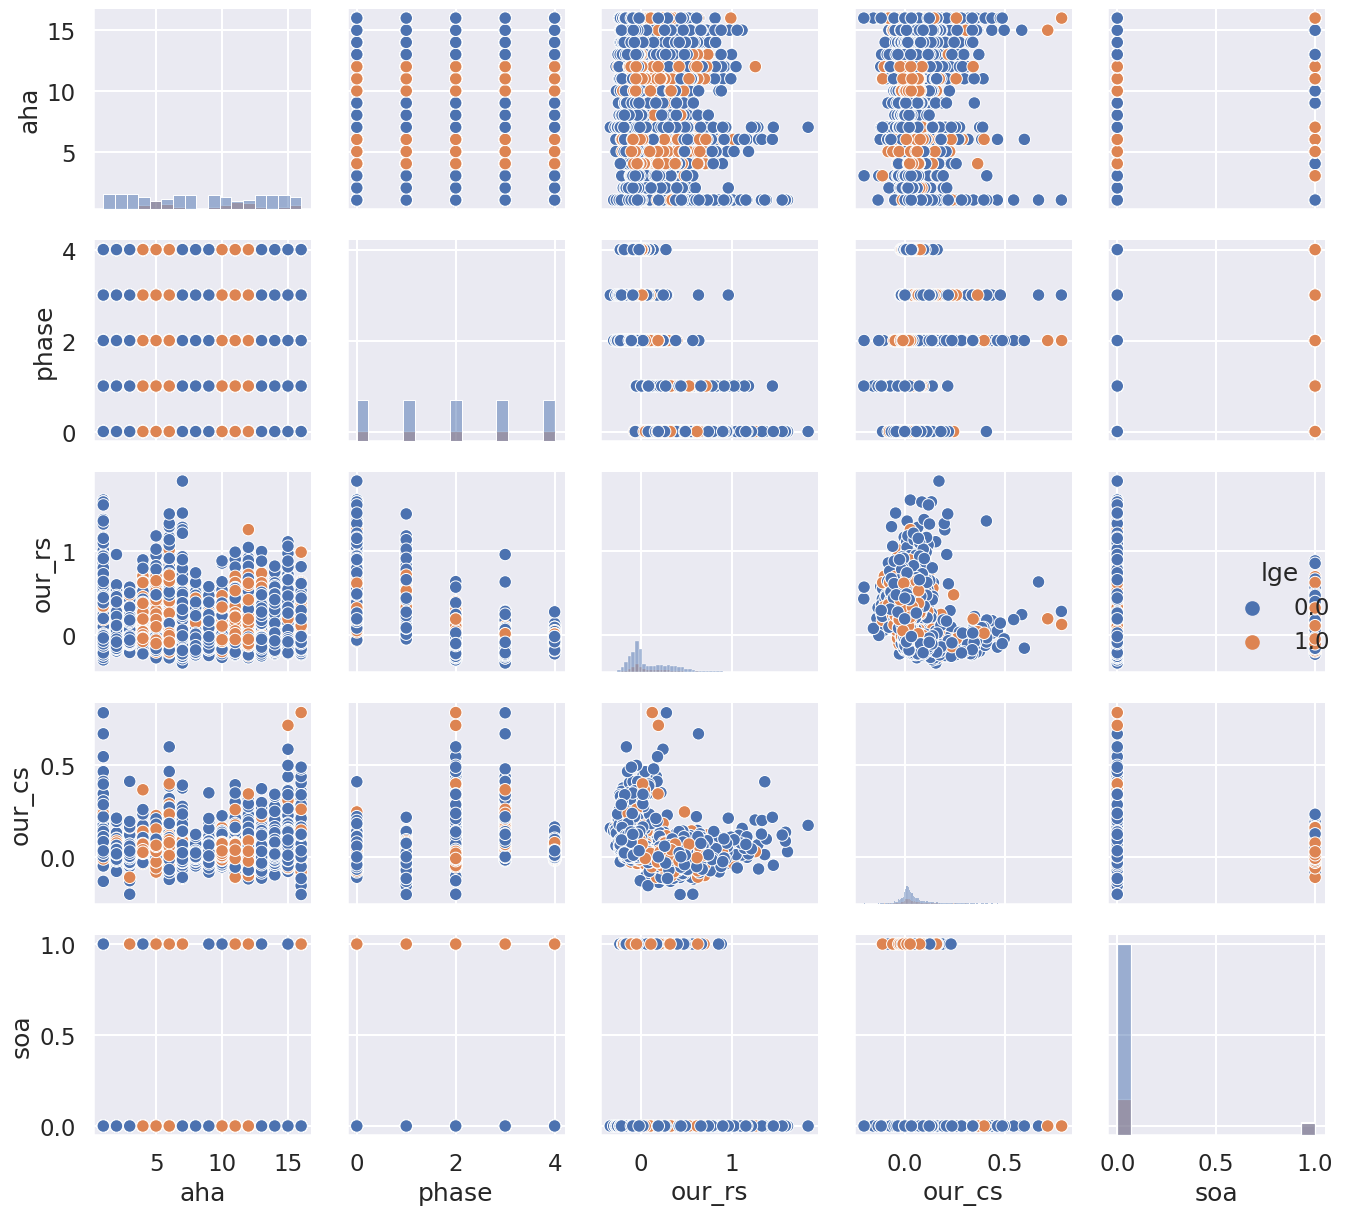

In [24]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_p2p,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## Peak Strain

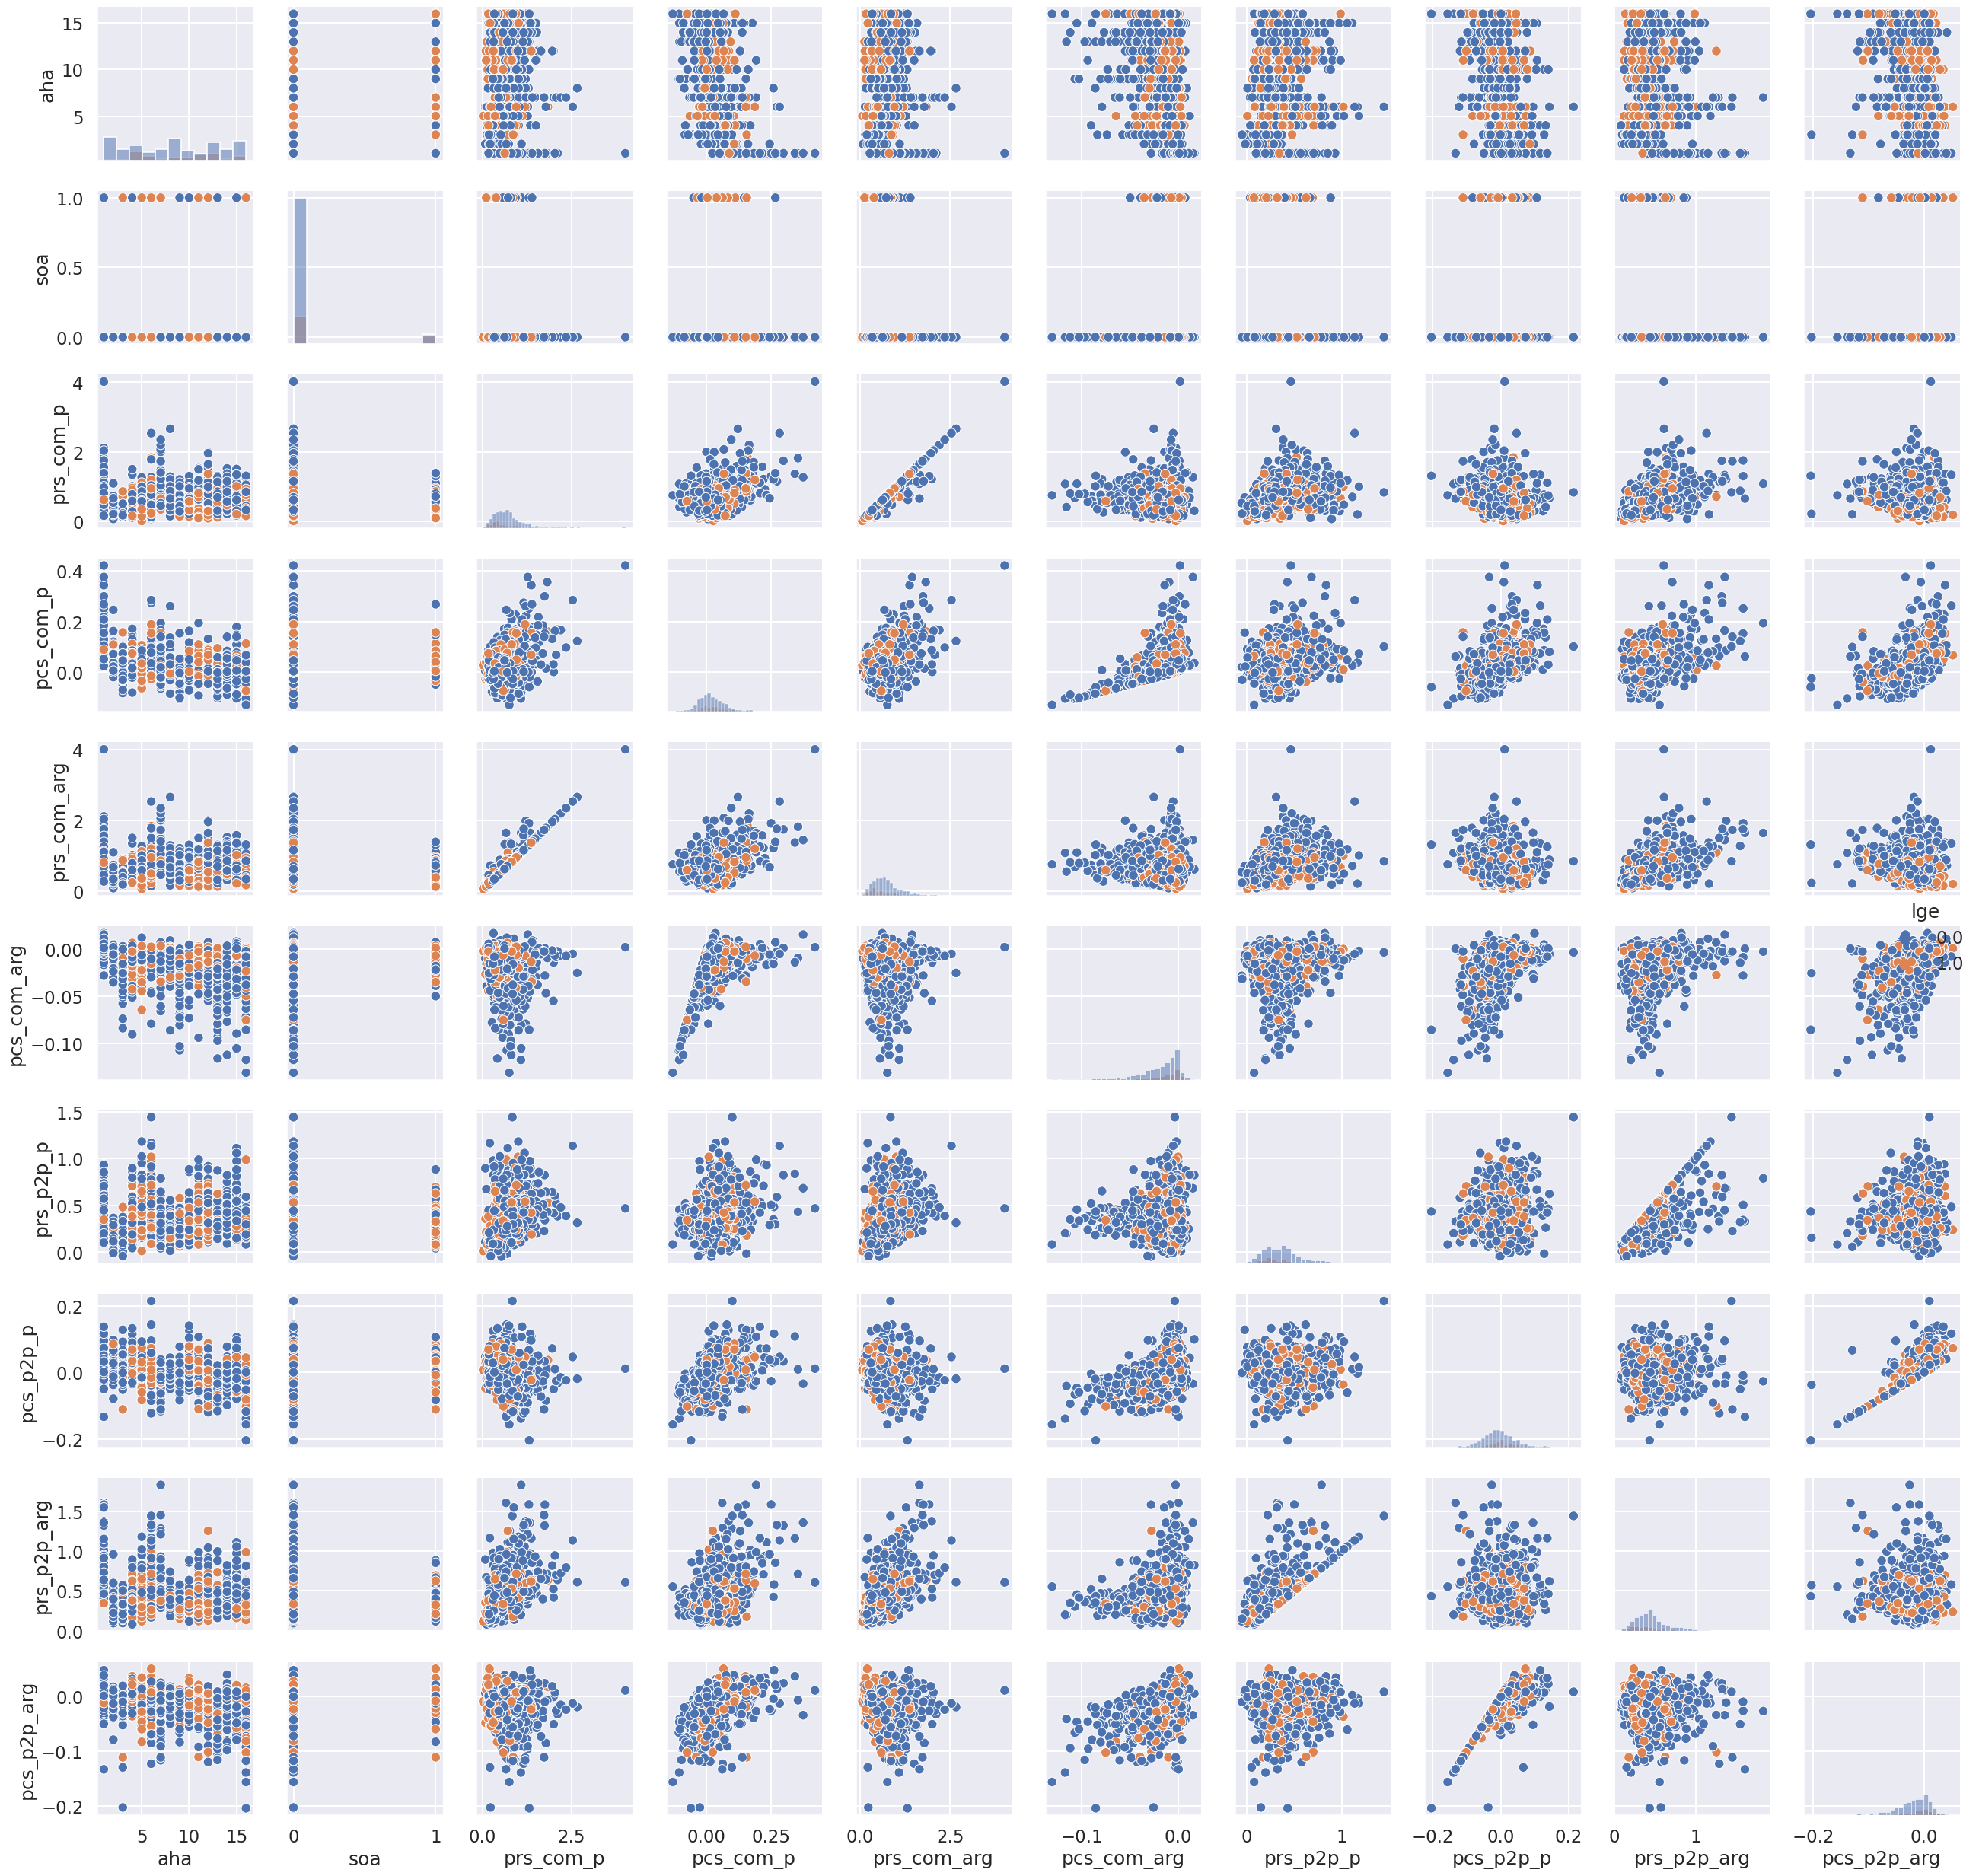

In [25]:
sb.set_context("talk")
g = sb.pairplot(data=df_peak,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Correlation plots

## Composed Strain

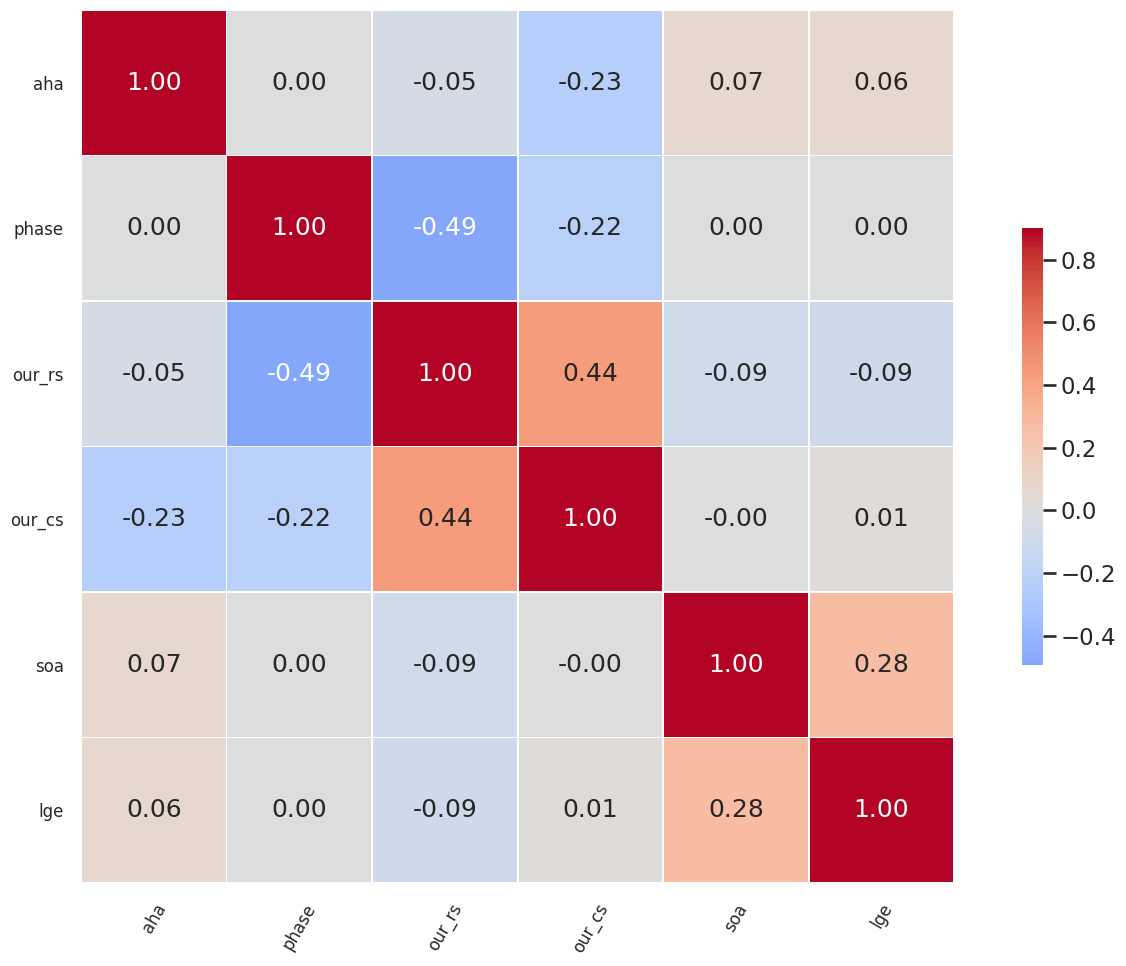

In [26]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_comp.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()
#fig.savefig('strain_corr_cvi_vs_ours.png')

## p2p Strain

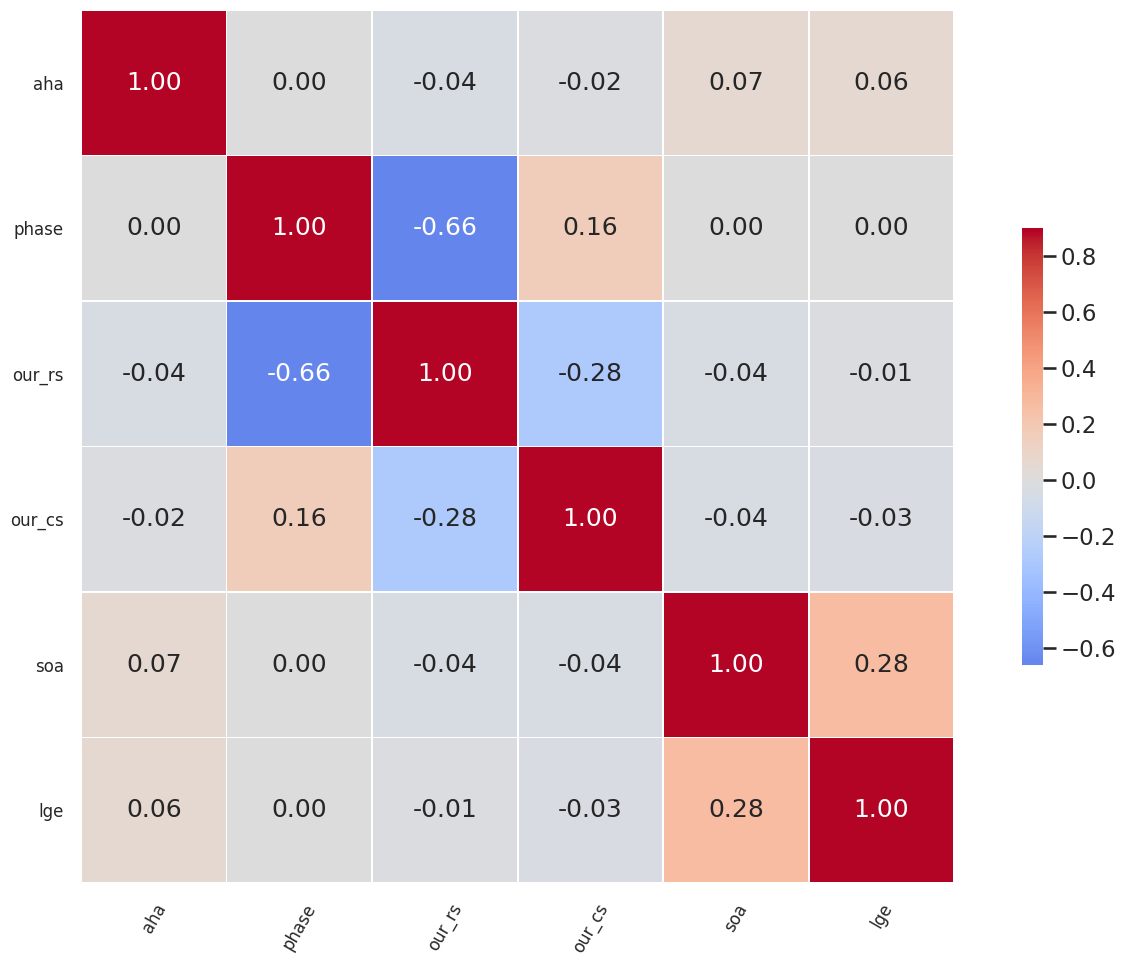

In [27]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_p2p.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()

## Peak Strain

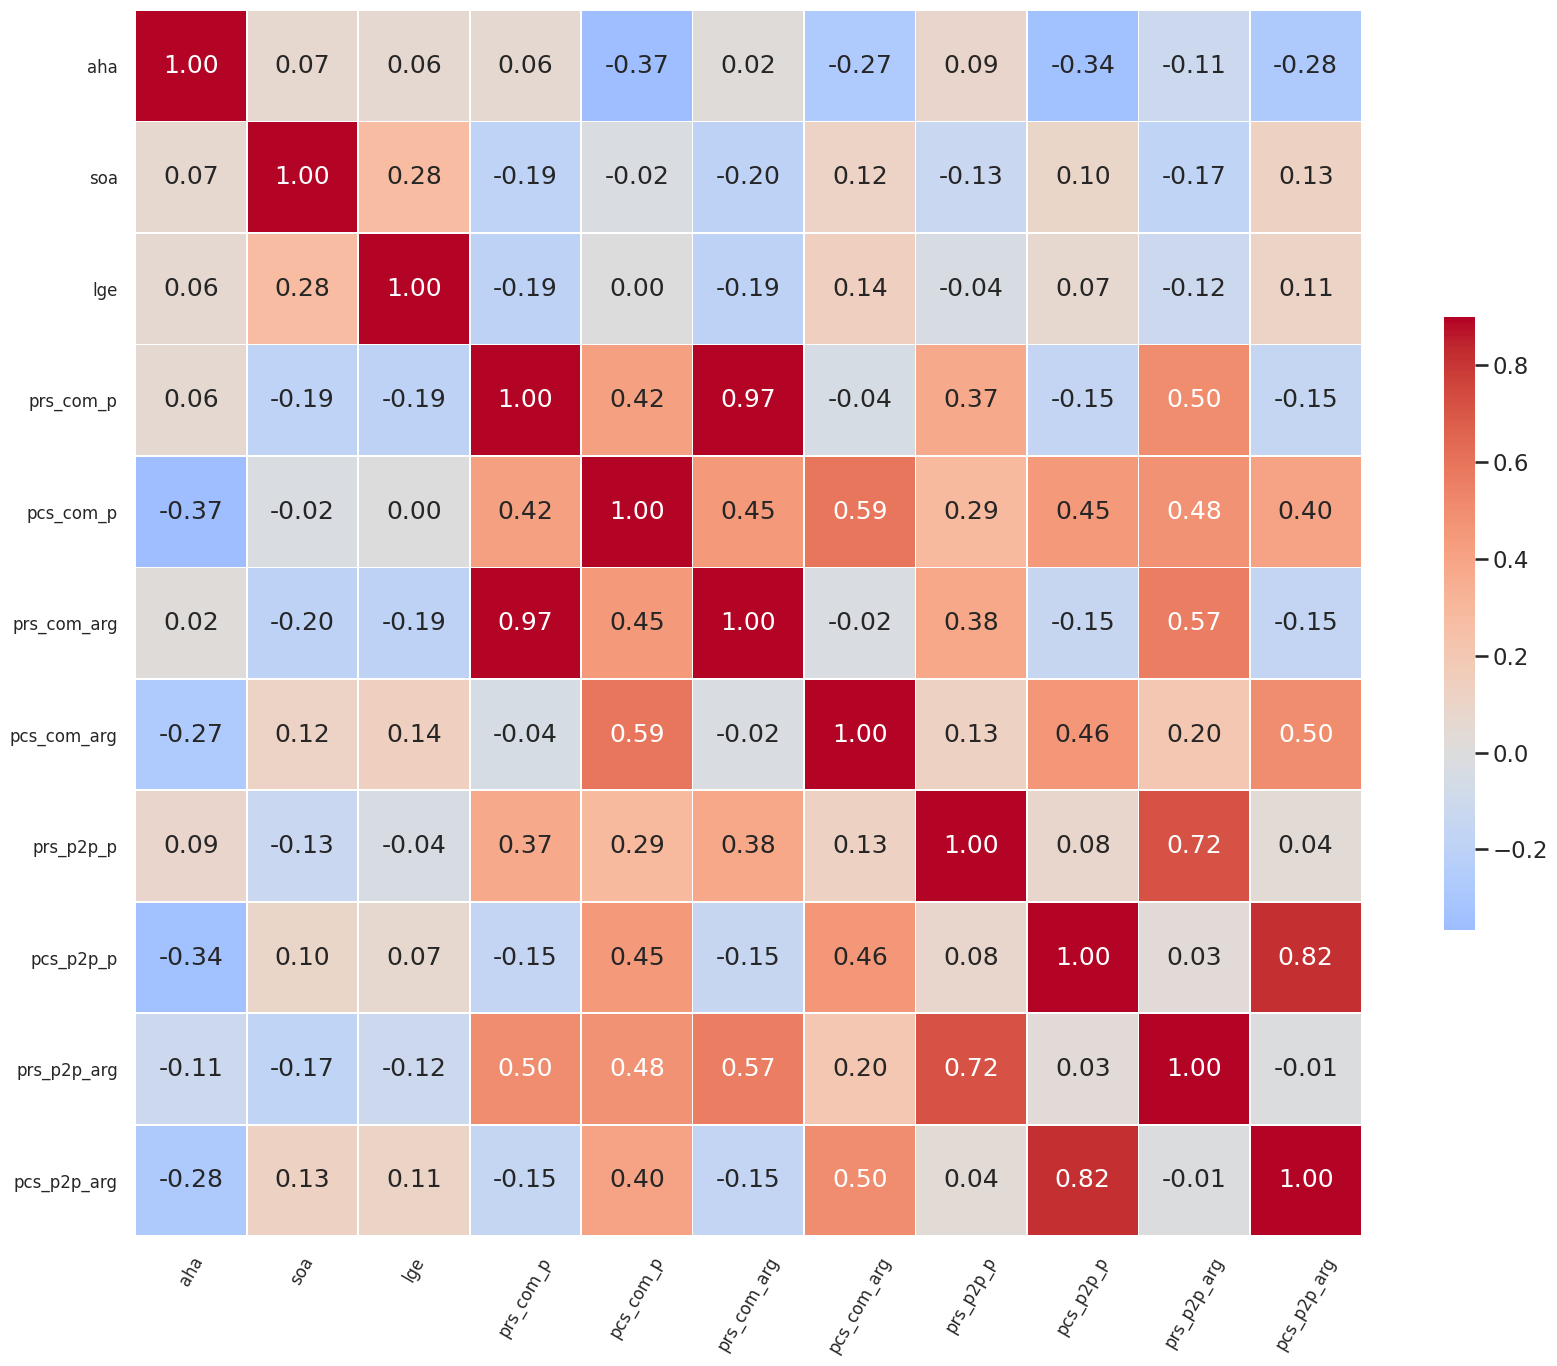

In [28]:
fig, ax = plt.subplots(figsize=(18,14)) 
corr = df_peak.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()

# Strain per phase

Extract one feature Vector per Patient (56 patients times 16 segments times 5 phases times two feature (rs, cs))

- 32 LGE positive patients
- 24 LGE negative patients

## Strain per patient from composed df (56 x 16 x 5 x 2) --> 56, 160

(56, 80)
(56, 160)
(56,)
(56,)
********** Logistic Regression **********
[0.75  0.875]
Recall: 0.81 (+/- 0.06) [Logistic Regression]
Accuracy: 0.61 (+/- 0.00) [Logistic Regression]
********** Random Forest **********
[0.6875 0.6875]
Recall: 0.69 (+/- 0.00) [Random Forest]
Accuracy: 0.43 (+/- 0.00) [Random Forest]
********** naive Bayes **********
[0.625 0.5  ]
Recall: 0.56 (+/- 0.06) [naive Bayes]
Accuracy: 0.52 (+/- 0.05) [naive Bayes]
********** scaled DecissionTree **********
[0.625 0.5  ]
Recall: 0.56 (+/- 0.06) [scaled DecissionTree]
Accuracy: 0.54 (+/- 0.00) [scaled DecissionTree]
********** KNN **********
[0.4375 0.375 ]
Recall: 0.41 (+/- 0.03) [KNN]
Accuracy: 0.43 (+/- 0.04) [KNN]
********** scaled SVC(poly) **********
[0.9375 0.875 ]
Recall: 0.91 (+/- 0.03) [scaled SVC(poly)]
Accuracy: 0.57 (+/- 0.04) [scaled SVC(poly)]
********** SVC(poly) **********
[0. 0.]
Recall: 0.00 (+/- 0.00) [SVC(poly)]
Accuracy: 0.43 (+/- 0.00) [SVC(poly)]
********** Ensemble **********
[0.625  0.6875

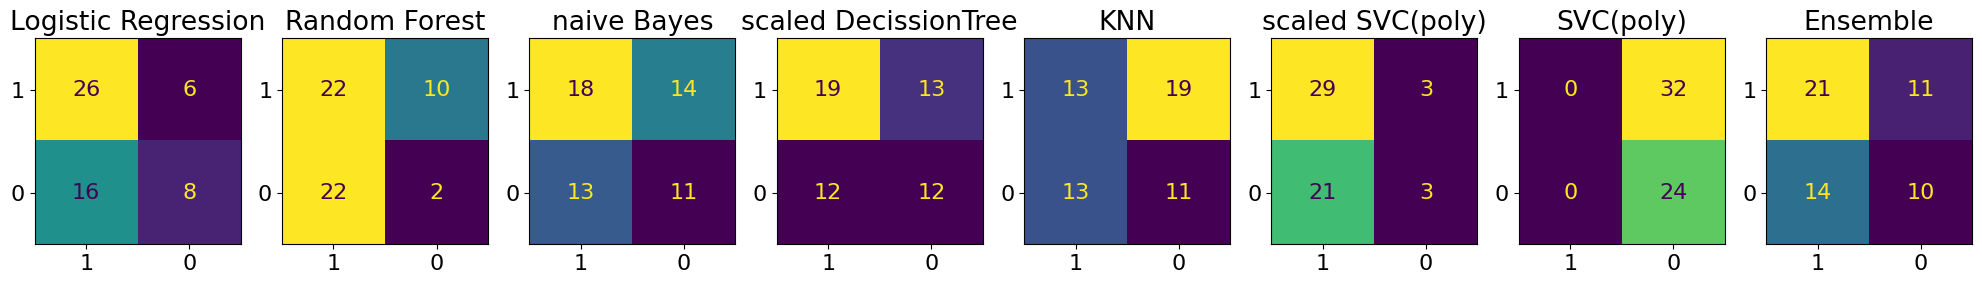

In [21]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p df (56 x 16 x 5 x 2) --> 56, 160

(56, 80)
(56, 160)
(56,)
(56,)
********** Logistic Regression **********
[0.5   0.625]
Recall: 0.56 (+/- 0.06) [Logistic Regression]
Accuracy: 0.43 (+/- 0.04) [Logistic Regression]
********** Random Forest **********
[0.9375 0.875 ]
Recall: 0.91 (+/- 0.03) [Random Forest]
Accuracy: 0.59 (+/- 0.02) [Random Forest]
********** naive Bayes **********
[0.5625 0.4375]
Recall: 0.50 (+/- 0.06) [naive Bayes]
Accuracy: 0.50 (+/- 0.00) [naive Bayes]
********** scaled DecissionTree **********
[0.625 0.5  ]
Recall: 0.56 (+/- 0.06) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.02) [scaled DecissionTree]
********** KNN **********
[0.8125 0.75  ]
Recall: 0.78 (+/- 0.03) [KNN]
Accuracy: 0.57 (+/- 0.00) [KNN]
********** scaled SVC(poly) **********
[0.9375 1.    ]
Recall: 0.97 (+/- 0.03) [scaled SVC(poly)]
Accuracy: 0.59 (+/- 0.02) [scaled SVC(poly)]
********** SVC(poly) **********
[0. 0.]
Recall: 0.00 (+/- 0.00) [SVC(poly)]
Accuracy: 0.43 (+/- 0.00) [SVC(poly)]
********** Ensemble **********
[0.5   0.625

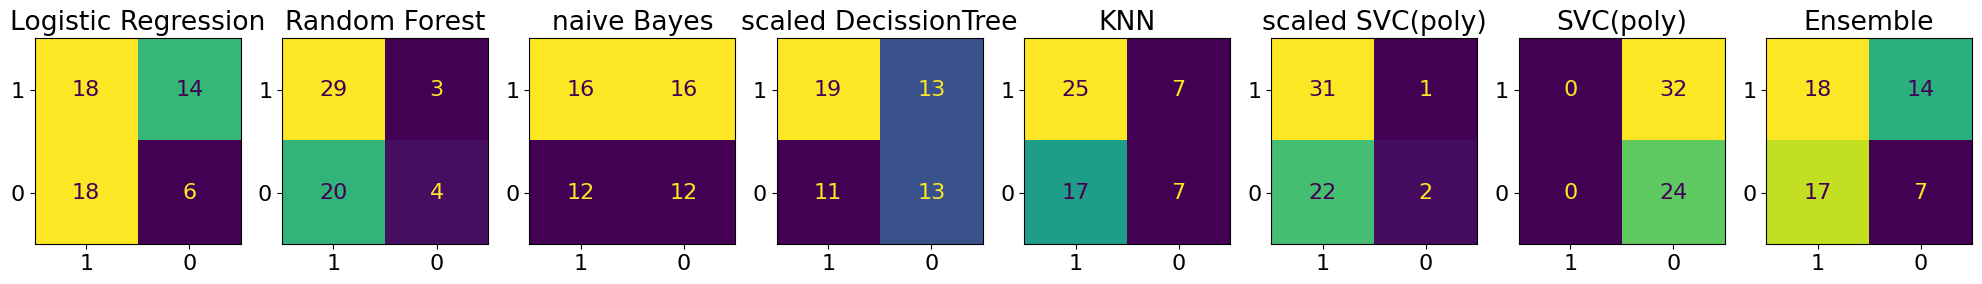

In [22]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p & composed df (56 x 16 x 5 x 2 x 2) --> 56, 320

# Peak Strain

- p2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

- ed2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

--> 320 features per patient

(56, 20)
(56, 80)
(56,)
(56,)
********** Logistic Regression **********
[0.42857143 0.83333333 0.33333333 0.66666667 0.85714286]
Recall: 0.62 (+/- 0.21) [Logistic Regression]
Accuracy: 0.50 (+/- 0.20) [Logistic Regression]
********** Random Forest **********
[0.42857143 1.         0.66666667 0.33333333 1.        ]
Recall: 0.69 (+/- 0.28) [Random Forest]
Accuracy: 0.47 (+/- 0.21) [Random Forest]
********** naive Bayes **********
[0.28571429 0.66666667 0.66666667 0.5        0.28571429]
Recall: 0.48 (+/- 0.17) [naive Bayes]
Accuracy: 0.42 (+/- 0.14) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.33333333 0.5        0.33333333 0.57142857]
Recall: 0.43 (+/- 0.09) [scaled DecissionTree]
Accuracy: 0.38 (+/- 0.04) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.83333333 0.33333333 0.66666667 0.28571429]
Recall: 0.54 (+/- 0.21) [KNN]
Accuracy: 0.55 (+/- 0.20) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         1.         1.         0.857142

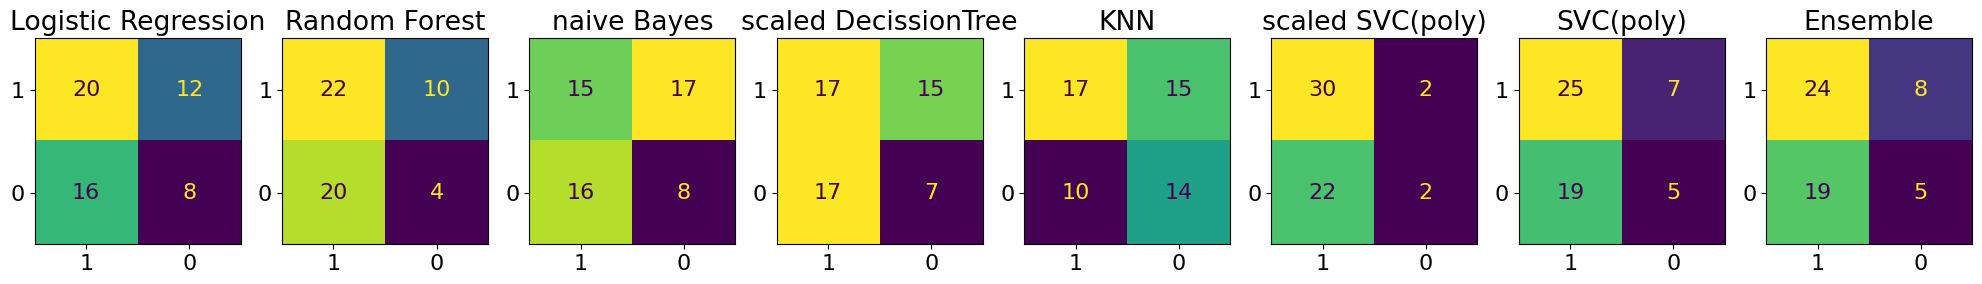

In [24]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc_p = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr_p = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr, xc_p, xr_p], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from composed df

(56, 4)
(56, 8)
(56,)
(56,)
********** Logistic Regression **********
[0.42857143 1.         0.66666667 0.66666667 0.57142857]
Recall: 0.67 (+/- 0.19) [Logistic Regression]
Accuracy: 0.63 (+/- 0.19) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.83333333 1.         0.83333333 0.71428571]
Recall: 0.82 (+/- 0.10) [Random Forest]
Accuracy: 0.70 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.57142857 0.83333333 1.         0.83333333 0.57142857]
Recall: 0.76 (+/- 0.17) [naive Bayes]
Accuracy: 0.63 (+/- 0.16) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.83333333 0.66666667 0.66666667 0.57142857]
Recall: 0.66 (+/- 0.10) [scaled DecissionTree]
Accuracy: 0.63 (+/- 0.22) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.16666667 0.66666667 0.         0.14285714]
Recall: 0.31 (+/- 0.26) [KNN]
Accuracy: 0.44 (+/- 0.08) [KNN]
********** scaled SVC(poly) **********
[0.57142857 0.83333333 1.         0.66666667 0.71428571

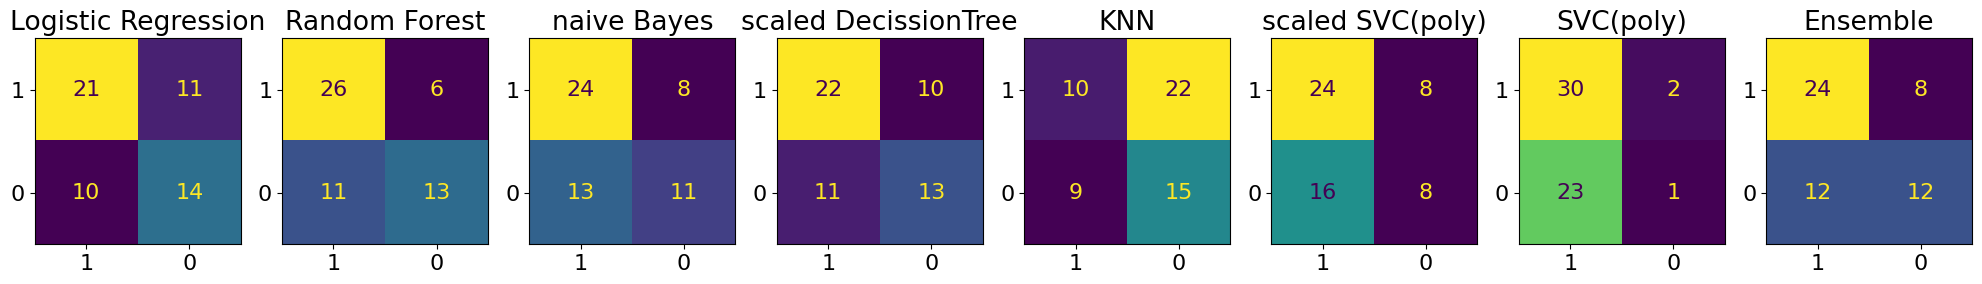

In [25]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (arg-min/max) per patient from composed df

(56, 4)
(56, 8)
(56,)
(56,)
********** Logistic Regression **********
[0.57142857 1.         0.66666667 0.66666667 0.71428571]
Recall: 0.72 (+/- 0.15) [Logistic Regression]
Accuracy: 0.70 (+/- 0.20) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.66666667 0.83333333 0.66666667 0.85714286]
Recall: 0.72 (+/- 0.11) [Random Forest]
Accuracy: 0.68 (+/- 0.18) [Random Forest]
********** naive Bayes **********
[0.57142857 1.         0.83333333 0.66666667 1.        ]
Recall: 0.81 (+/- 0.17) [naive Bayes]
Accuracy: 0.67 (+/- 0.17) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.83333333 0.66666667 0.66666667 0.85714286]
Recall: 0.72 (+/- 0.11) [scaled DecissionTree]
Accuracy: 0.61 (+/- 0.12) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.33333333 0.16666667 0.5        0.71428571]
Recall: 0.46 (+/- 0.19) [KNN]
Accuracy: 0.52 (+/- 0.17) [KNN]
********** scaled SVC(poly) **********
[0.71428571 0.83333333 1.         0.83333333 0.42857143

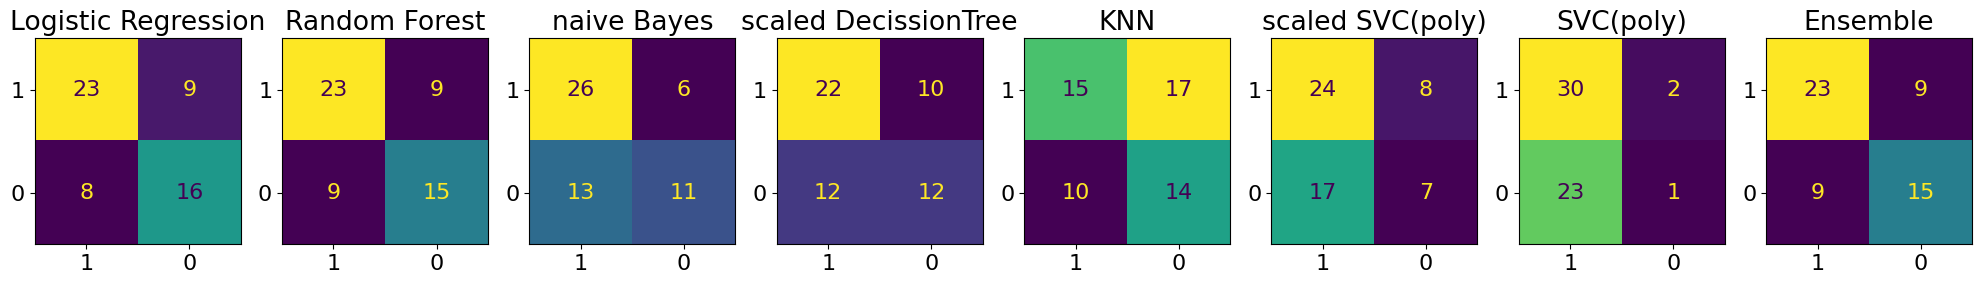

In [26]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from p2p df

(56, 4)
(56, 8)
(56,)
(56,)
********** Logistic Regression **********
[0.42857143 0.5        1.         0.66666667 0.42857143]
Recall: 0.60 (+/- 0.22) [Logistic Regression]
Accuracy: 0.62 (+/- 0.04) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.83333333 1.         0.83333333 0.85714286]
Recall: 0.88 (+/- 0.06) [Random Forest]
Accuracy: 0.71 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.57142857 0.66666667 0.83333333 0.83333333 0.85714286]
Recall: 0.75 (+/- 0.11) [naive Bayes]
Accuracy: 0.70 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[1.         0.66666667 0.66666667 0.66666667 0.85714286]
Recall: 0.77 (+/- 0.14) [scaled DecissionTree]
Accuracy: 0.71 (+/- 0.12) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.5        1.         0.83333333 0.42857143]
Recall: 0.61 (+/- 0.27) [KNN]
Accuracy: 0.59 (+/- 0.20) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         0.83333333 1.         0.85714286

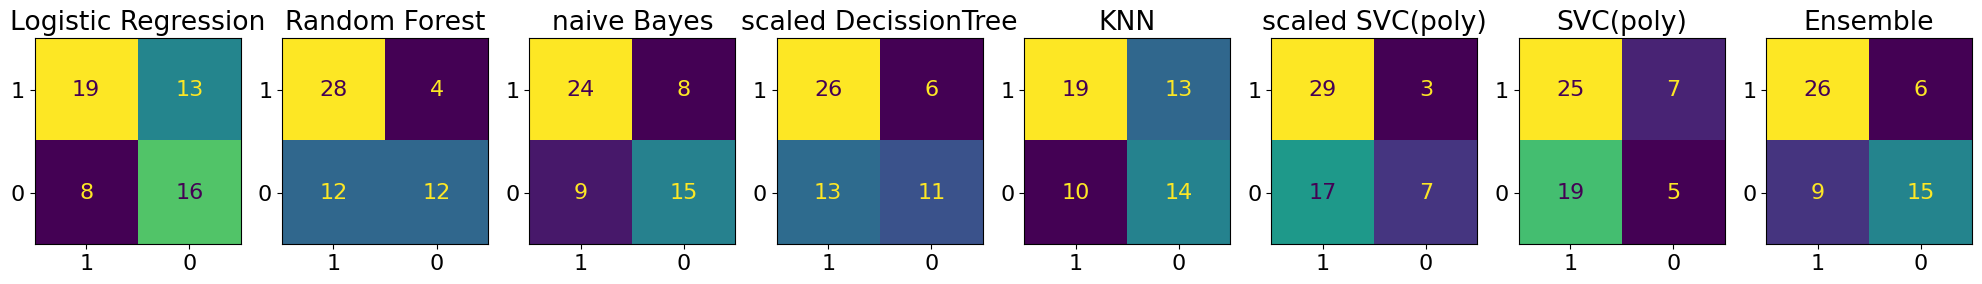

In [27]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## !!! Strain (arg-min/max) per patient from p2p df

works best for mid-cavity-segments

(56, 16)
(56, 32)
(56,)
(56,)
********** Logistic Regression **********
[0.5625 0.8125]
Recall: 0.69 (+/- 0.12) [Logistic Regression]
Accuracy: 0.57 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.75   0.6875]
Recall: 0.72 (+/- 0.03) [Random Forest]
Accuracy: 0.54 (+/- 0.00) [Random Forest]
********** naive Bayes **********
[0.6875 0.75  ]
Recall: 0.72 (+/- 0.03) [naive Bayes]
Accuracy: 0.66 (+/- 0.02) [naive Bayes]
********** scaled DecissionTree **********
[0.75  0.625]
Recall: 0.69 (+/- 0.06) [scaled DecissionTree]
Accuracy: 0.59 (+/- 0.02) [scaled DecissionTree]
********** KNN **********
[0.6875 0.625 ]
Recall: 0.66 (+/- 0.03) [KNN]
Accuracy: 0.52 (+/- 0.05) [KNN]
********** scaled SVC(poly) **********
[0.9375 0.375 ]
Recall: 0.66 (+/- 0.28) [scaled SVC(poly)]
Accuracy: 0.55 (+/- 0.02) [scaled SVC(poly)]
********** SVC(poly) **********
[0. 0.]
Recall: 0.00 (+/- 0.00) [SVC(poly)]
Accuracy: 0.43 (+/- 0.00) [SVC(poly)]
********** Ensemble **********
[0.5625 0.3

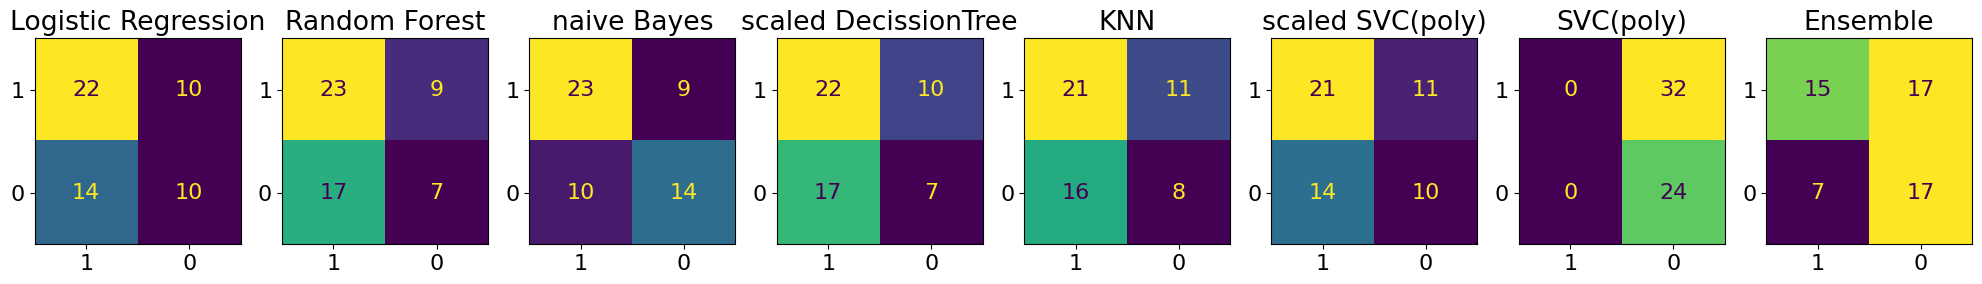

In [10]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## (Most robust) Strains concatenatet per patient

(56, 6)
(56, 48)
(56,)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 1.         0.57142857]
Recall: 0.79 (+/- 0.14) [Logistic Regression]
Accuracy: 0.72 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.83333333 0.83333333 1.         0.71428571]
Recall: 0.79 (+/- 0.14) [Random Forest]
Accuracy: 0.73 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.5        0.66666667 1.        ]
Recall: 0.78 (+/- 0.20) [naive Bayes]
Accuracy: 0.75 (+/- 0.10) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.5        0.16666667 1.         0.57142857]
Recall: 0.59 (+/- 0.27) [scaled DecissionTree]
Accuracy: 0.61 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.66666667 0.66666667 0.83333333 0.71428571]
Recall: 0.72 (+/- 0.06) [KNN]
Accuracy: 0.73 (+/- 0.08) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         1.         1.         1.       

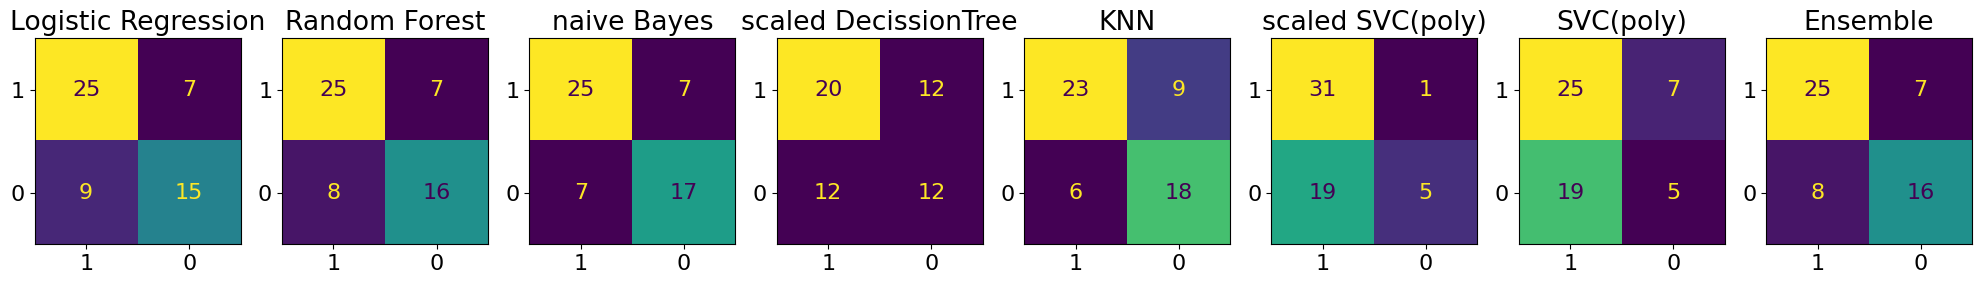

In [57]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc2 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr2 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc3 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr3 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc4 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr4 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr,xc2,xr2,xc3,xr3,xc4,xr4], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

# Strain per Segment

(896, 5)
(896, 10)
(896, 5)
(896,)
********** Logistic Regression **********
[0.69318182 0.56818182]
Recall: 0.63 (+/- 0.06) [Logistic Regression]
Accuracy: 0.60 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.03409091 0.01136364]
Recall: 0.02 (+/- 0.01) [Random Forest]
Accuracy: 0.79 (+/- 0.01) [Random Forest]
********** naive Bayes **********
[0.27272727 0.53409091]
Recall: 0.40 (+/- 0.13) [naive Bayes]
Accuracy: 0.73 (+/- 0.00) [naive Bayes]
********** scaled DecissionTree **********
[0.22727273 0.31818182]
Recall: 0.27 (+/- 0.05) [scaled DecissionTree]
Accuracy: 0.74 (+/- 0.01) [scaled DecissionTree]
********** KNN **********
[0.15909091 0.04545455]
Recall: 0.10 (+/- 0.06) [KNN]
Accuracy: 0.76 (+/- 0.01) [KNN]
********** scaled SVC(poly) **********
[0.44318182 0.52272727]
Recall: 0.48 (+/- 0.04) [scaled SVC(poly)]
Accuracy: 0.62 (+/- 0.05) [scaled SVC(poly)]
********** SVC(poly) **********
[0. 0.]
Recall: 0.00 (+/- 0.00) [SVC(poly)]
Accuracy: 0.80 (+/- 0.00)

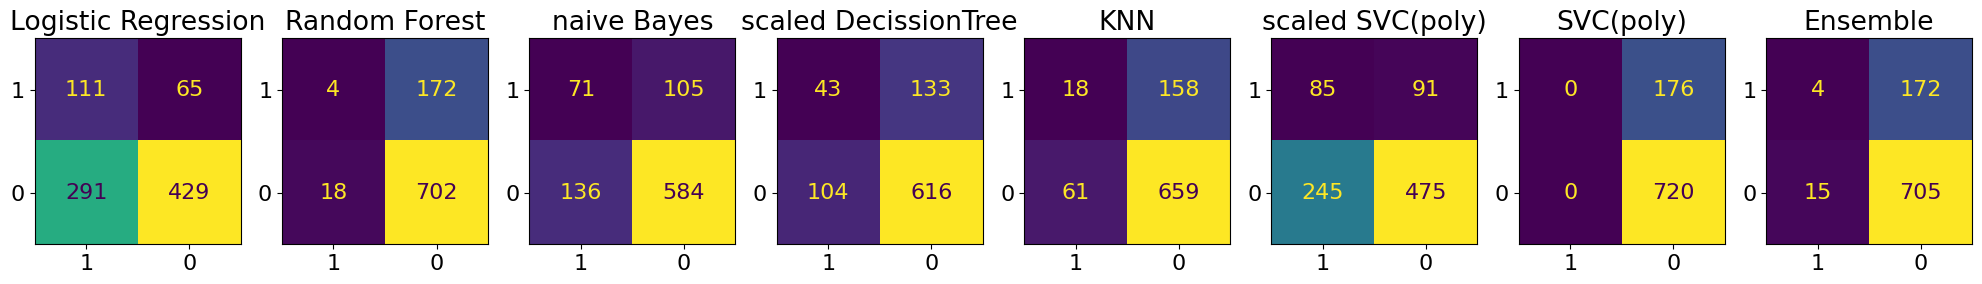

In [25]:
# per patient with peak values from the phases and argmax
# 56 patients x 16 segments = 896
# per segment we take the circumferential strain
xc = np.stack(df_strain_p2p.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x_ = np.concatenate([xc,xr], axis=1)
print(x_.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y_ = np.stack(df_strain_comp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
print(y_.shape)
y_ = y_.sum(axis=1)>0
print(y_.shape)
cross_validate_f1(x_,y_)

In [114]:
# fit one model per segment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
# iterate over the aha segments
# create a sub dataframe of PRS, PCS or comp, p2p
# with the shape: patients, features (56, 2 or 56,psp+com)
# extract x and y for this segment
estimators = []
preds = []
y_tests = []
patients = df_strain_p2p.pat.unique()
X_train, X_test, _, _ = train_test_split(
    patients, patients, test_size=0.2, random_state=42)
# iterate over the segments
for seg in df_strain_p2p.aha.unique():
    print("segment: {}".format(seg))
    # create a temp sub df for only the train patients
    df_strain_p2p_temp = df_strain_p2p[df_strain_p2p['pat'].isin(X_train)]
    df_strain_comp_temp = df_strain_comp[df_strain_comp['pat'].isin(X_train)]
    df_strain_p2p_test = df_strain_p2p[df_strain_p2p['pat'].isin(X_test)]
    df_strain_comp_test = df_strain_comp[df_strain_comp['pat'].isin(X_test)]
    
    # filter the current segment
    seg_of_interest= [seg]
    df_strain_p2p_temp = df_strain_p2p_temp[df_strain_p2p_temp['aha'].isin(seg_of_interest)]
    df_strain_comp_temp = df_strain_comp_temp[df_strain_comp_temp['aha'].isin(seg_of_interest)]
    df_strain_p2p_test = df_strain_p2p_test[df_strain_p2p_test['aha'].isin(seg_of_interest)]
    df_strain_comp_test = df_strain_comp_test[df_strain_comp_test['aha'].isin(seg_of_interest)]
    
    # 280,7 --> 56 patients x 5 phases = 280; and ['pat', 'aha', 'phase', 'our_rs', 'our_cs', 'soa', 'lge']
    cs_p2p = np.stack(df_strain_p2p_temp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    cs_comp = np.stack(df_strain_comp_temp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    x_ = cs_comp#np.concatenate([cs_p2p, cs_comp], axis=1)
    y_ = np.stack(df_strain_p2p_temp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
    y_ = y_.sum(axis=1)>0
    
    cs_p2p_test = np.stack(df_strain_p2p_test.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    cs_comp_test = np.stack(df_strain_comp_test.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    x_test = cs_comp_test#np.concatenate([cs_p2p_test, cs_comp_test], axis=1)
    y_test = np.stack(df_strain_p2p_test.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
    y_test = y_test.sum(axis=1)>0
    if y_.sum()>4:
        clf_ = make_pipeline(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced'))
        clf_.fit(x_, y_)
        train_preds = clf_.predict(x_)
        estimators.append(('{}'.format(seg), clf_))
        pred_ = clf_.predict(x_test)
        preds.append(pred_)
        y_tests.append(y_test)
        print(accuracy_score(y_, train_preds))
        print(precision_score(y_, train_preds))
        print(accuracy_score(y_test, pred_))
        print(precision_score(y_test, pred_))
        #cross_validate_f1(x_,y_); plt.show()
    else:
        print('only {} pos examples, no splits possible'.format(y_.sum()))

segment: 1
only 1 pos examples, no splits possible
segment: 2
only 1 pos examples, no splits possible
segment: 3
only 3 pos examples, no splits possible
segment: 4
1.0
1.0
0.3333333333333333
0.0
segment: 5
1.0
1.0
0.6666666666666666
0.6666666666666666
segment: 6
1.0
1.0
0.5
0.25
segment: 7
only 4 pos examples, no splits possible
segment: 8
only 4 pos examples, no splits possible
segment: 9
1.0
1.0
0.75
0.4
segment: 10
1.0
1.0
0.5833333333333334
0.25
segment: 11
1.0
1.0
0.5833333333333334
0.6
segment: 12
1.0
1.0
0.3333333333333333
0.25
segment: 13
1.0
1.0
0.75
0.0
segment: 14
only 3 pos examples, no splits possible
segment: 15
1.0
1.0
0.75
0.0
segment: 16
1.0
1.0
0.8333333333333334
0.5


In [115]:
preds_stack = np.stack(preds, axis=0)
print(preds_stack.shape)
y_tests_stack = np.stack(y_tests, axis=0)
for p in range(y_tests_stack.shape[1]):
    print('--'*10)
    print(preds_stack[:,p].sum())
    print(y_tests_stack[:,p].sum())

(10, 12)
--------------------
4
0
--------------------
3
7
--------------------
4
4
--------------------
2
0
--------------------
3
0
--------------------
6
3
--------------------
8
7
--------------------
3
0
--------------------
3
0
--------------------
3
5
--------------------
4
4
--------------------
4
0


In [30]:
# check for nan and infinit values
x[~np.isfinite(x)]

NameError: name 'x' is not defined

# Unsupervised Clustering

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#temp_2d = TSNE(n_components=2, perplexity=4, learning_rate=50).fit_transform(x)
#temp_2d = PCA(n_components=2).fit_transform(x)
temp_2d = make_pipeline(
    #StandardScaler(),
    MinMaxScaler(),
    #NeighborhoodComponentsAnalysis(n_components=4, random_state=42),
    TSNE(n_components=2, perplexity=2, learning_rate=500, method='exact', init='pca')
    ).fit_transform(x)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(56, 3)


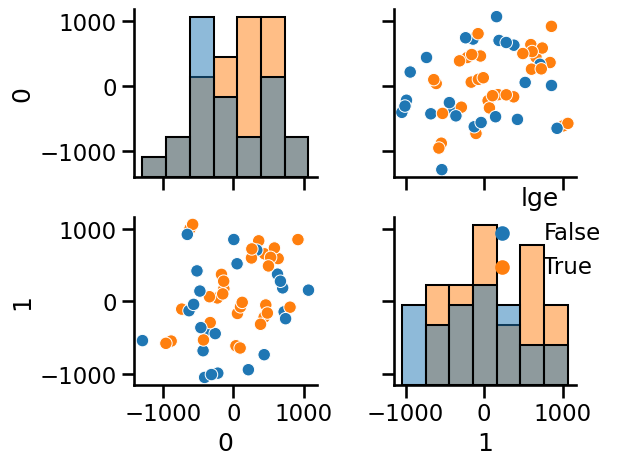

In [40]:
sb.set_context("talk")
df_temp = pd.DataFrame(temp_2d)
df_temp['lge'] = y
print(df_temp.shape)
g = sb.pairplot(data=df_temp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

In [ ]:
cross_validate_f1(temp_2d,y)

********** Logistic Regression **********
[0.57142857 0.5        0.16666667 0.33333333 0.71428571]
Recall: 0.46 (+/- 0.19) [Logistic Regression]
Accuracy: 0.46 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.66666667 0.66666667 1.         0.85714286]
Recall: 0.78 (+/- 0.13) [Random Forest]
Accuracy: 0.72 (+/- 0.06) [Random Forest]
********** naive Bayes **********
[0.85714286 0.83333333 0.33333333 1.         0.85714286]
Recall: 0.78 (+/- 0.23) [naive Bayes]
Accuracy: 0.61 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.66666667 0.66666667 1.         1.        ]
Recall: 0.81 (+/- 0.16) [scaled DecissionTree]
Accuracy: 0.73 (+/- 0.08) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.5        0.16666667 0.66666667 0.57142857]
Recall: 0.50 (+/- 0.17) [KNN]
Accuracy: 0.59 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[1.         0.5        0.5        0.5        0.57142857]
Recall: 0.61 (+/- 0.19) [s

# Gridsearch for the SVC Estimator pipeline

In [153]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__C', 'clf__break_ties', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [11]:

def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]

    penalties = ['l2']
    solvers = ['liblinear', 'lbfgs']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1'], 
                        refit='balanced_accuracy',
                        cv=skf,
                        n_jobs=16)
gs = create_grid_search()
gs = gs.fit(x, y)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/met

In [12]:
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(1632, 63)

In [13]:
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.015247      0.000226         0.007478        0.000219   
1          0.015050      0.000505         0.007450        0.000418   
2          0.013898      0.000266         0.006793        0.000282   
3          0.125150      0.005435         0.025017        0.000659   
4          0.121734      0.001730         0.024868        0.000380   
...             ...           ...              ...             ...   
1627       0.423348      0.009076         0.108169        0.002541   
1628       0.422545      0.002781         0.105703        0.000869   
1629       0.805994      0.073149         0.192107        0.033620   
1630       0.829788      0.036970         0.182965        0.030990   
1631       0.827323      0.019937         0.201344        0.009944   

                                                                param_clf  \
0         RandomForestClassifier(class_weight='balanced', random_state=1)   
1         RandomForestClassifier(class_weight='balanced', random_state=1)   
2         RandomForestClassifier(class_weight='balanced', random_state=1)   
3         RandomForestClassifier(class_weight='balanced', random_state=1)   
4         RandomForestClassifier(class_weight='balanced', random_state=1)   
...                                                                   ...   
1627  ExtraTreesClassifier(max_depth=5, n_estimators=250, random_state=1)   
1628  ExtraTreesClassifier(max_depth=5, n_estimators=250, random_state=1)   
1629  ExtraTreesClassifier(max_depth=5, n_estimators=250, random_state=1)   
1630  ExtraTreesClassifier(max_depth=5, n_estimators=250, random_state=1)   
1631  ExtraTreesClassifier(max_depth=5, n_estimators=250, random_state=1)   

     param_clf__class_weight param_clf__n_estimators      param_scaler  \
0                       None                      10  StandardScaler()   
1                       None                      10    MinMaxScaler()   
2                       None                      10              None   
3                       None                     100  StandardScaler()   
4                       None                     100    MinMaxScaler()   
...                      ...                     ...               ...   
1627                     NaN                     500    MinMaxScaler()   
1628                     NaN                     500              None   
1629                     NaN                    1000  StandardScaler()   
1630                     NaN                    1000    MinMaxScaler()   
1631                     NaN                    1000              None   

     param_clf__C param_clf__gamma  ... rank_test_precision split0_test_f1  \
0             NaN              NaN  ...                 463       0.666667   
1             NaN              NaN  ...                 463       0.666667   
2             NaN              NaN  ...                 463       0.666667   
3             NaN              NaN  ...                1252       0.533333   
4             NaN              NaN  ...                1252       0.533333   
...           ...              ...  ...                 ...            ...   
1627          NaN              NaN  ...                 670       0.571429   
1628          NaN              NaN  ...                 670       0.571429   
1629          NaN              NaN  ...                 407       0.571429   
1630          NaN              NaN  ...                 407       0.571429   
1631          NaN              NaN  ...                 407       0.571429   

     split1_test_f1 split2_test_f1  split3_test_f1  split4_test_f1  \
0          0.400000       0.500000        0.666667        0.363636   
1          0.400000       0.500000        0.666667        0.363636   
2          0.400000       0.500000        0.666667        0.363636   
3          0.545455       0.461538        0.533333        0.666667   
4          0.545455       0.461538        0.533333        0.6666

In [14]:
results.sort_values(by=['rank_test_f1','rank_test_accuracy','rank_test_recall'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
596      0.742326          0.971429            0.607576   
599      0.742326          0.971429            0.607576   
608      0.742326          0.971429            0.607576   
611      0.742326          0.971429            0.607576   
620      0.742326          0.971429            0.607576   

                                                                                                                                                                        params_str  
596       {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'scaler': None}  
599   {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.001, 'clf__kernel': 'sigmoid', 'scaler': None}  
608      {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': None}  
611  {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.0001, 'clf__kernel': 'sigmoid', 'scaler': None}  
620       {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': None}

In [15]:
results.sort_values(by=['rank_test_balanced_accuracy', 'rank_test_recall','rank_test_f1'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
875       0.644872          0.657143            0.643939   
1091      0.644872          0.657143            0.643939   
1307      0.644872          0.657143            0.643939   
1523      0.644872          0.657143            0.643939   
766       0.701026          0.761905            0.645455   

                                                                                                                                                                                params_str  
875        {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}  
1091    {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 1000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}  
1307   {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}  
1523  {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}  
766    {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': MinMaxScaler()}

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



params: {'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}
[0.57142857 0.16666667 0.83333333 1.         0.71428571]
Recall: 0.66 (+/- 0.28) []
Accuracy: 0.64 (+/- 0.16) []
Precision: 0.68 (+/- 0.14) []
Balanced Accuracy: 0.64 (+/- 0.15) []
F1: 0.64 (+/- 0.22) []
AUC: 0.64


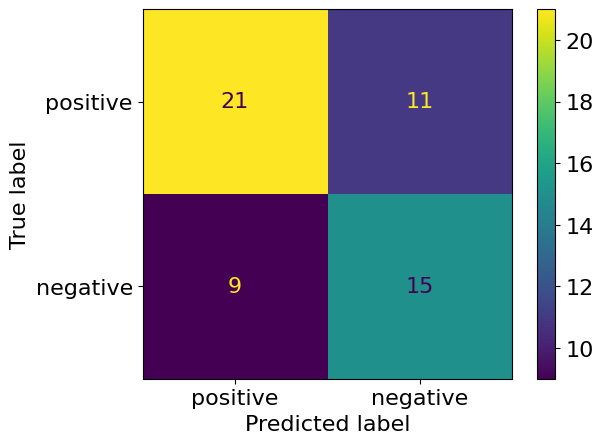

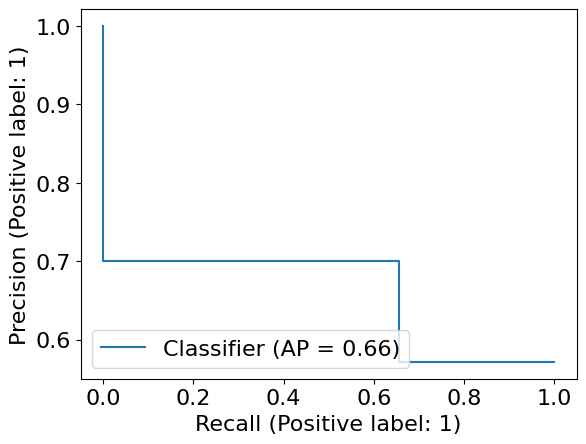

In [17]:
def plot_report(clf, x, y, label=''):
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(clf, x, y, cv=skf)
    scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy', 'balanced_accuracy', 'precision', 'f1'], cv=skf)
    print('params: {}'.format(label))
    print(scores['test_recall'])
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), ""))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), ""))
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores['test_precision'].mean(), scores['test_precision'].std(), ""))
    print("Balanced Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), ""))
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), ""))
    print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)
    
plot_report(gs.best_estimator_, x, y, label=gs.best_params_)
plt.show()

In [20]:
print(gs.best_params_)
gs.best_estimator_

{'clf': SVC(C=100, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': None}


Pipeline(steps=[('scaler', None),
                ('clf', SVC(C=100, class_weight='balanced', kernel='sigmoid'))])

params: [('scaler', None), ('clf', SVC(C=10, class_weight='balanced', gamma=0.001))]
[1.         1.         1.         1.         0.85714286]
Recall: 0.97 (+/- 0.06) []
Accuracy: 0.61 (+/- 0.11) []
Precision: 0.62 (+/- 0.12) []
Balanced Accuracy: 0.56 (+/- 0.12) []
F1: 0.74 (+/- 0.06) []
AUC: 0.55


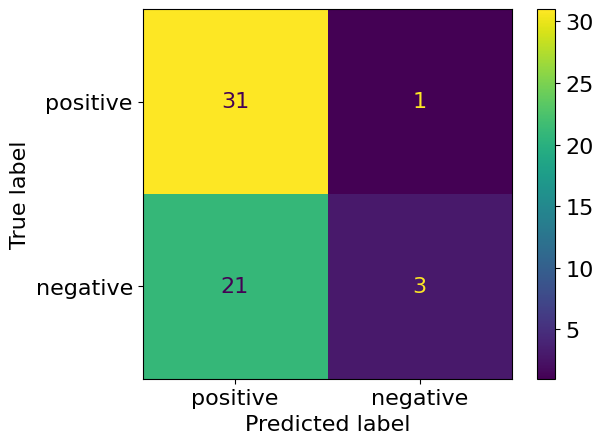

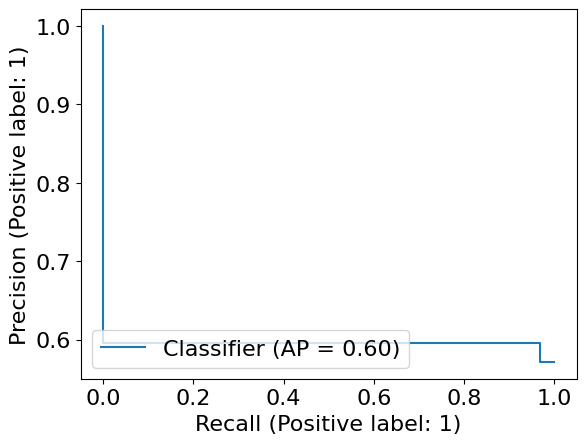

In [19]:
# Best pipeline according to the balanced accuracy
#{'clf': SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}
best_clf = Pipeline(steps=[('scaler',None,),('clf',SVC(C=10, gamma=0.001, class_weight='balanced', kernel='rbf'))])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('scaler', StandardScaler()), ('clf', SVC(C=10, gamma=0.01, kernel='poly'))]
[1. 1. 1. 1. 1.]
Recall: 1.00 (+/- 0.00) []
Accuracy: 0.57 (+/- 0.04) []
Precision: 0.57 (+/- 0.04) []
Balanced Accuracy: 0.50 (+/- 0.00) []
F1: 0.73 (+/- 0.03) []
AUC: 0.50


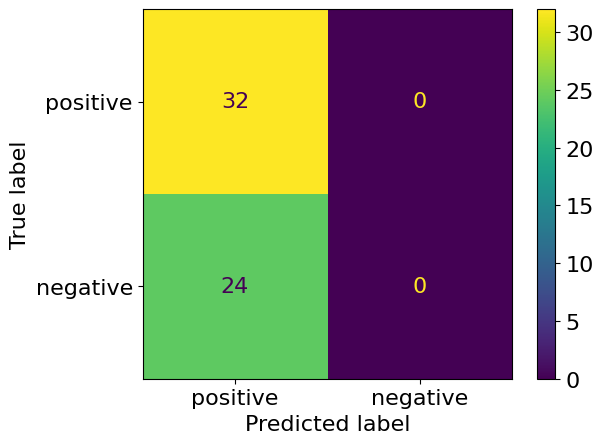

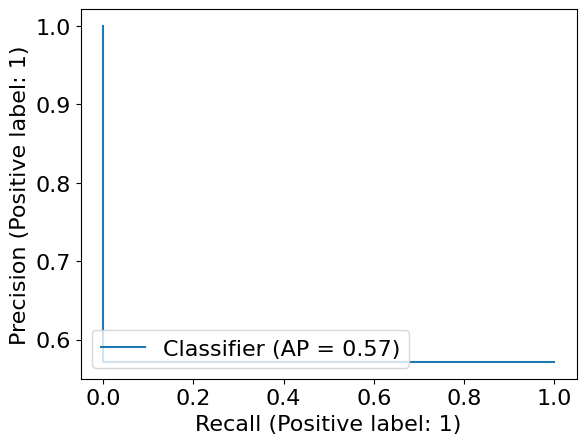

In [34]:
# this one has the highest recall == 1, but no real information gain
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=10, class_weight=None, gamma=0.01, kernel='poly'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.57142857 0.83333333 0.66666667 0.5        0.85714286]
Recall: 0.69 (+/- 0.14) []
Accuracy: 0.68 (+/- 0.14) []
Precision: 0.75 (+/- 0.17) []
Balanced Accuracy: 0.68 (+/- 0.14) []
F1: 0.71 (+/- 0.13) []
AUC: 0.68


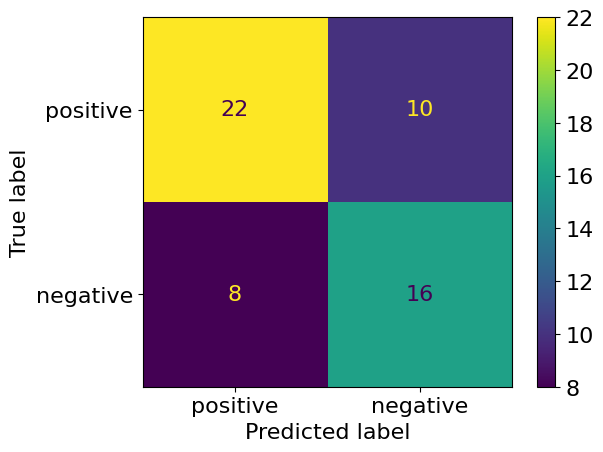

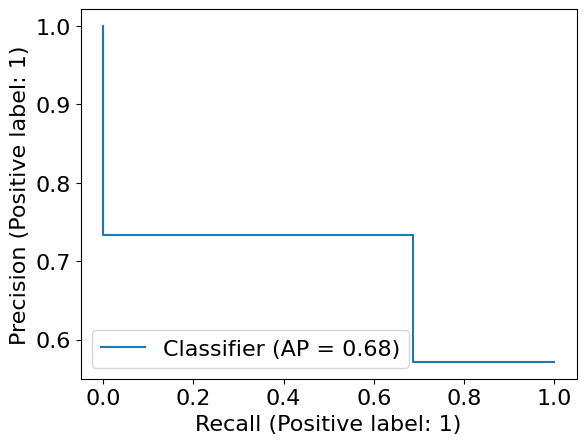

In [35]:
# this one has a high recall, but still a valid accuracy
best_clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='scale',class_weight='balanced', C=1, degree=3))
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.57142857 0.83333333 0.66666667 0.5        0.85714286]
Recall: 0.69 (+/- 0.14) []
Accuracy: 0.68 (+/- 0.14) []
Precision: 0.75 (+/- 0.17) []
Balanced Accuracy: 0.68 (+/- 0.14) []
F1: 0.71 (+/- 0.13) []
AUC: 0.68


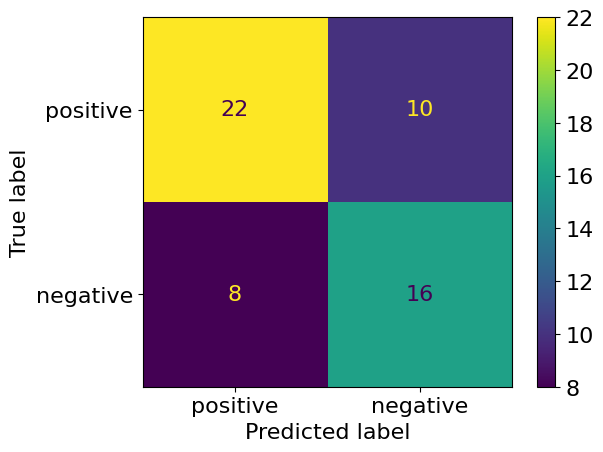

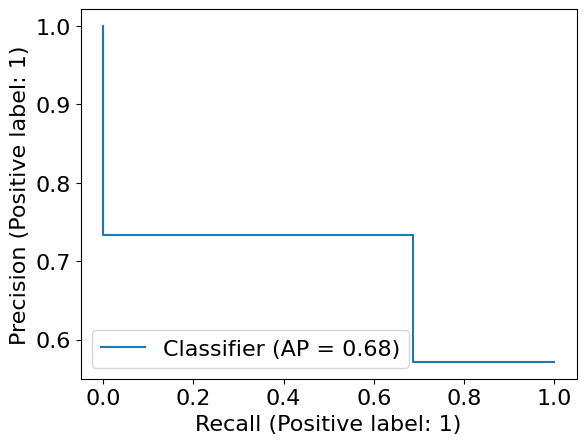

In [36]:
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

# Model Essemble according to different metrics

In [37]:
# best balanced accuracy
results.sort_values(by='rank_test_balanced_accuracy', inplace=True, ascending=True)
params_best_ba = results.head(1)['params'].values[0]
print(params_best_ba)
clf_best_ba = gs.best_estimator_.set_params(**params_best_ba)

{'clf': SVC(C=1000.0, class_weight='balanced', gamma=0.01), 'clf__C': 1000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}


In [38]:
# best f1
results.sort_values(by='rank_test_f1', inplace=True,ascending=True)
params_best_f1 = results.head(1)['params'].values[0]
print(params_best_f1)
clf_best_f1 = gs.best_estimator_.set_params(**params_best_f1)

{'clf': SVC(C=1000.0, class_weight='balanced', gamma=0.01), 'clf__C': 1000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}


In [39]:
# best average precision
results.sort_values(by='rank_test_precision', inplace=True,ascending=True)
params_best_ap = results.head(1)['params'].values[0]
print(params_best_ap)
clf_best_ap = gs.best_estimator_.set_params(**params_best_ap)

{'clf': SVC(C=1000.0, class_weight='balanced', gamma=0.01), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'poly', 'scaler': MinMaxScaler()}


In [40]:
eclf = VotingClassifier(
        estimators=[
            ('ba', clf_best_ba), 
            ('f1', clf_best_f1),
            ('ap', clf_best_ap)
                   ],
        voting='hard')

params: ensamble
[0.42857143 0.83333333 0.33333333 0.33333333 0.42857143]
Recall: 0.47 (+/- 0.19) []
Accuracy: 0.62 (+/- 0.04) []
Precision: 0.86 (+/- 0.17) []
Balanced Accuracy: 0.66 (+/- 0.06) []
F1: 0.57 (+/- 0.09) []
AUC: 0.65


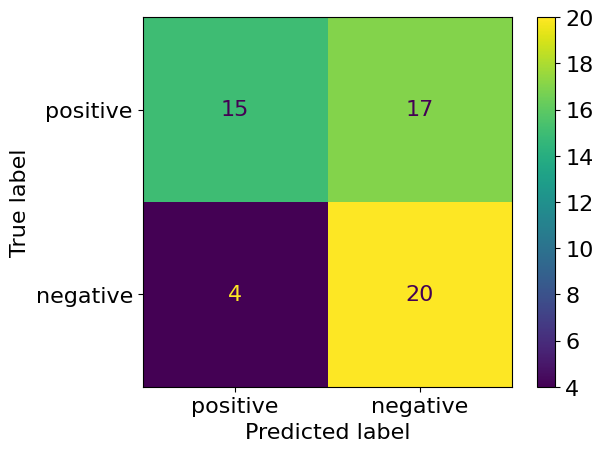

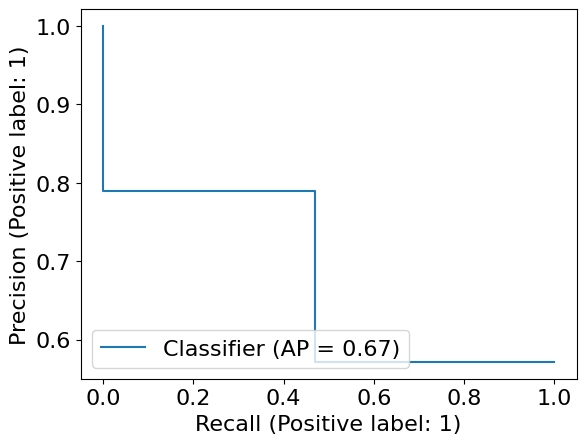

In [41]:
plot_report(eclf, x, y, label='ensamble');plt.show()

Precision: 0.74
Recall: 0.81
F1 Score: 0.78
Accuracy: 0.73
Balanced accuracy: 0.72
AUC: 0.72


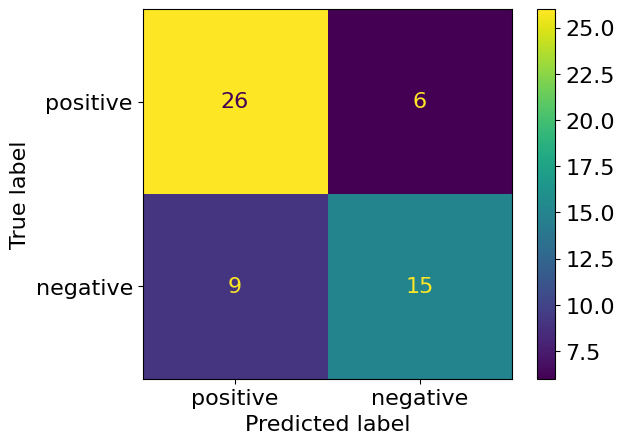

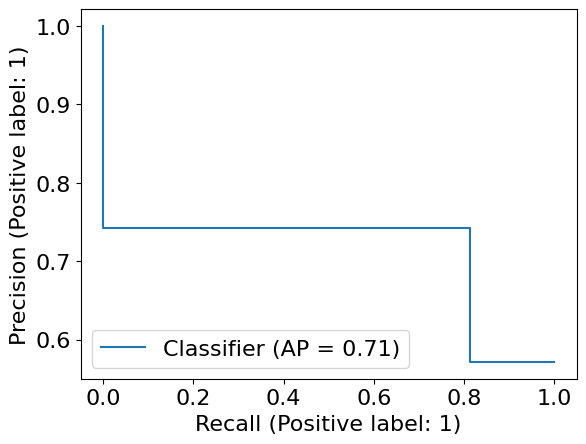

In [73]:
# re-calculate the scores of the current best clinical practice
from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)

TP = 26
FN = 6
FP = 9
TN = 15

tp = [1]*TP
y_pred = tp
y = tp

tn = [0]*TN
y_pred = y_pred + tn
y = y + tn

fp_pred = [1]*FP
fp_y = [0]*FP
y_pred = y_pred + fp_pred
y = y + fp_y

fn_pred = [0]*FN
fn_y = [1]*FN
y_pred = y_pred + fn_pred
y = y + fn_y


import sklearn
CBP_results = sklearn.metrics.precision_recall_fscore_support(y,y_pred, average='binary')
print('Precision: {:.2f}\nRecall: {:.2f}'.format(CBP_results[0], CBP_results[1]))
print('F1 Score: {:.2f}'.format(sklearn.metrics.f1_score(y,y_pred)))
print('Accuracy: {:.2f}'.format(sklearn.metrics.accuracy_score(y,y_pred)))
print('Balanced accuracy: {:.2f}'.format(sklearn.metrics.balanced_accuracy_score(y,y_pred)))
print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
disp = PrecisionRecallDisplay.from_predictions(y,y_pred)


# calculate the measures for the Current best practice



# Precision = TP / (TP+FP) 
